In [1]:
from pandas.core.common import random_state
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from Classification.cnn1D_model_with_freq import VibrationDataset, CNN1D_DS, FrequencyDomainCNN
from Classification.cnn1D_model_with_freq import train_and_evaluate
import torch
from torch.utils.data import Dataset, DataLoader, random_split,Subset
from sklearn.model_selection import train_test_split
import random
import pandas as pd
from utils.baseline_xai import predict_single, summarize_attributions
from utils.baseline_xai import grad_times_input_relevance, smoothgrad_relevance, occlusion_signal_relevance, occlusion_simpler_relevance
from  visualization.relevance_visualization import visualize_with_label_attribution, visualize_lrp_single_sample, visualize_lrp_dft, visualize_lrp_fft, visualize_crp_heatmap
from utils.xai_implementation import compute_lrp_relevance, compute_dft_lrp_relevance, compute_fft_lrp_relevance
from sklearn.model_selection import GroupKFold
from collections import Counter
from utils.crp_utils import *

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# Load dataset, Stratify based on Lable and Operation, so that the train, test, val sets have appropriate amount of each group

data_directory = "../data/final/new_selection/normalized_windowed_downsampled_data"
dataset = VibrationDataset(data_directory, augment_bad=False)

# Create a combined stratification key (label_operation)
stratify_key = [f"{lbl}_{op}" for lbl, op in zip(dataset.labels, dataset.operations)]

# Stratified split by both label and operation
train_idx, temp_idx = train_test_split(
    range(len(dataset)), test_size=0.3, stratify=stratify_key
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=[stratify_key[i] for i in temp_idx]
)

# Create Subset datasets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Verify split sizes and label distribution
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")
print(f"Train good: {sum(dataset.labels[train_idx] == 0)}, Train bad: {sum(dataset.labels[train_idx] == 1)}")
print(f"Val good: {sum(dataset.labels[val_idx] == 0)}, Val bad: {sum(dataset.labels[val_idx] == 1)}")
print(f"Test good: {sum(dataset.labels[test_idx] == 0)}, Test bad: {sum(dataset.labels[test_idx] == 1)}")

# Class ratios
train_ratio = sum(dataset.labels[train_idx] == 0) / sum(dataset.labels[train_idx] == 1)
val_ratio = sum(dataset.labels[val_idx] == 0) / sum(dataset.labels[val_idx] == 1)
test_ratio = sum(dataset.labels[test_idx] == 0) / sum(dataset.labels[test_idx] == 1)
print(f"Class ratio (good/bad) - Train: {train_ratio:.2f}, Val: {val_ratio:.2f}, Test: {test_ratio:.2f}")

# Operation distribution
train_ops = Counter(dataset.operations[train_idx])
val_ops = Counter(dataset.operations[val_idx])
test_ops = Counter(dataset.operations[test_idx])
print(f"Train operations: {train_ops}")
print(f"Val operations: {val_ops}")
print(f"Test operations: {test_ops}")

# Creating DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train size: 5250, Val size: 1125, Test size: 1126
Train good: 3924, Train bad: 1326
Val good: 839, Val bad: 286
Test good: 843, Test bad: 283
Class ratio (good/bad) - Train: 2.96, Val: 2.93, Test: 2.98
Train operations: Counter({np.str_('OP06'): 806, np.str_('OP04'): 694, np.str_('OP10'): 568, np.str_('OP12'): 559, np.str_('OP02'): 551, np.str_('OP11'): 534, np.str_('OP08'): 442, np.str_('OP14'): 330, np.str_('OP01'): 321, np.str_('OP07'): 279, np.str_('OP05'): 166})
Val operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 148, np.str_('OP10'): 121, np.str_('OP12'): 120, np.str_('OP02'): 119, np.str_('OP11'): 114, np.str_('OP08'): 94, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 36})
Test operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 149, np.str_('OP10'): 122, np.str_('OP12'): 119, np.str_('OP02'): 118, np.str_('OP11'): 115, np.str_('OP08'): 95, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 35})


Using device: cuda
Epoch [1/30] - Train Loss: 0.3730, Train Acc: 0.8442 - Val Loss: 0.1696, Val Acc: 0.9564 
Epoch [2/30] - Train Loss: 0.1057, Train Acc: 0.9684 - Val Loss: 0.0529, Val Acc: 0.9840 
Epoch [3/30] - Train Loss: 0.0436, Train Acc: 0.9884 - Val Loss: 0.0623, Val Acc: 0.9787 
Epoch [4/30] - Train Loss: 0.0287, Train Acc: 0.9920 - Val Loss: 0.0151, Val Acc: 0.9947 
Epoch [5/30] - Train Loss: 0.0264, Train Acc: 0.9926 - Val Loss: 0.0150, Val Acc: 0.9947 
Epoch [6/30] - Train Loss: 0.0221, Train Acc: 0.9935 - Val Loss: 0.0313, Val Acc: 0.9902 
Epoch [7/30] - Train Loss: 0.0187, Train Acc: 0.9950 - Val Loss: 0.0163, Val Acc: 0.9947 
Epoch [8/30] - Train Loss: 0.0133, Train Acc: 0.9973 - Val Loss: 0.0134, Val Acc: 0.9964 
Epoch [9/30] - Train Loss: 0.0169, Train Acc: 0.9954 - Val Loss: 0.0145, Val Acc: 0.9964 
Epoch [10/30] - Train Loss: 0.0110, Train Acc: 0.9970 - Val Loss: 0.0116, Val Acc: 0.9964 
Epoch [11/30] - Train Loss: 0.0083, Train Acc: 0.9981 - Val Loss: 0.0065, Val Ac

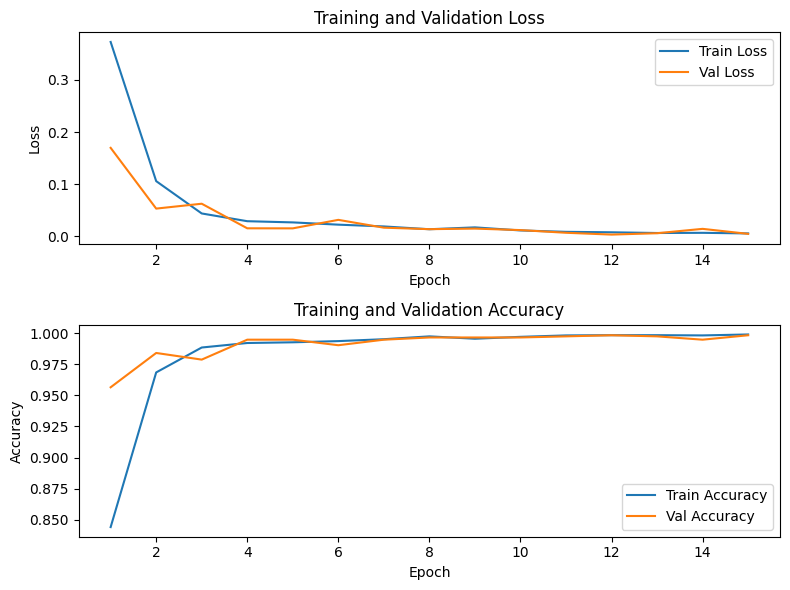

In [12]:
freq_model = train_and_evaluate(train_loader, val_loader, test_loader, EralyStopping=True)


In [14]:
# Save the trained model
torch.save(freq_model.state_dict(), "../cnn1d_freq2.ckpt")
print("✅ Model saved to cnn1d_freq2.ckpt")
freq_model.to(device)
freq_model.eval()  # Switch to evaluation mode
print("✅ Model loaded and ready for explanations")
print(f"✅ Model is structured as  \n {freq_model}")


✅ Model saved to cnn1d_freq2.ckpt
✅ Model loaded and ready for explanations
✅ Model is structured as  
 FrequencyDomainCNN(
  (time_cnn): CNN1D_DS(
    (feature_extractor): Sequential(
      (0): Conv1d(3, 16, kernel_size=(9,), stride=(1,))
      (1): GroupNorm(4, 16, eps=1e-05, affine=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv1d(16, 32, kernel_size=(7,), stride=(1,))
      (5): GroupNorm(4, 32, eps=1e-05, affine=True)
      (6): ReLU()
      (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
      (9): GroupNorm(4, 64, eps=1e-05, affine=True)
      (10): ReLU()
      (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): AdaptiveAvgPool1d(output_size=1)
    )
    (classifier): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Dro

### Explain the Model

#### choose a good sample

In [19]:

# Choose a random index
random.seed(45)
sample_batch, label_batch = next(iter(test_loader))
random_index = random.randint(0, len(sample_batch[1]) - 1)

# Get a single sample using your dataset's __getitem__ method
sample_idx = random_index  # Your selected index
data_tuple, label = dataset[sample_idx]  # This gives ((time_data, freq_data), label)

# Unpack the data tuple
time_data, freq_data = data_tuple

# Add batch dimension and move to device
time_data = time_data.unsqueeze(0).to(device)
freq_data = freq_data.unsqueeze(0).to(device)
label = torch.tensor([label]).to(device)

# Make prediction
with torch.no_grad():
    # Pass both time and frequency data to the model
    # This depends on how your model's forward method is implemented
    output = freq_model((time_data, freq_data))
    _, predicted_label = torch.max(output, 1)

print(f"Random Index: {sample_idx}, Predicted_label:{predicted_label.item()}, True_label:{label.item()}, Sample_time_shape:{time_data.shape}, Sample_freq_shape:{freq_data.shape}, lable_shape:{label.shape}")


Random Index: 69, Predicted_label:0, True_label:0, Sample_time_shape:torch.Size([1, 3, 2000]), Sample_freq_shape:torch.Size([1, 3, 1001]), lable_shape:torch.Size([1])


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 69 Label: Good


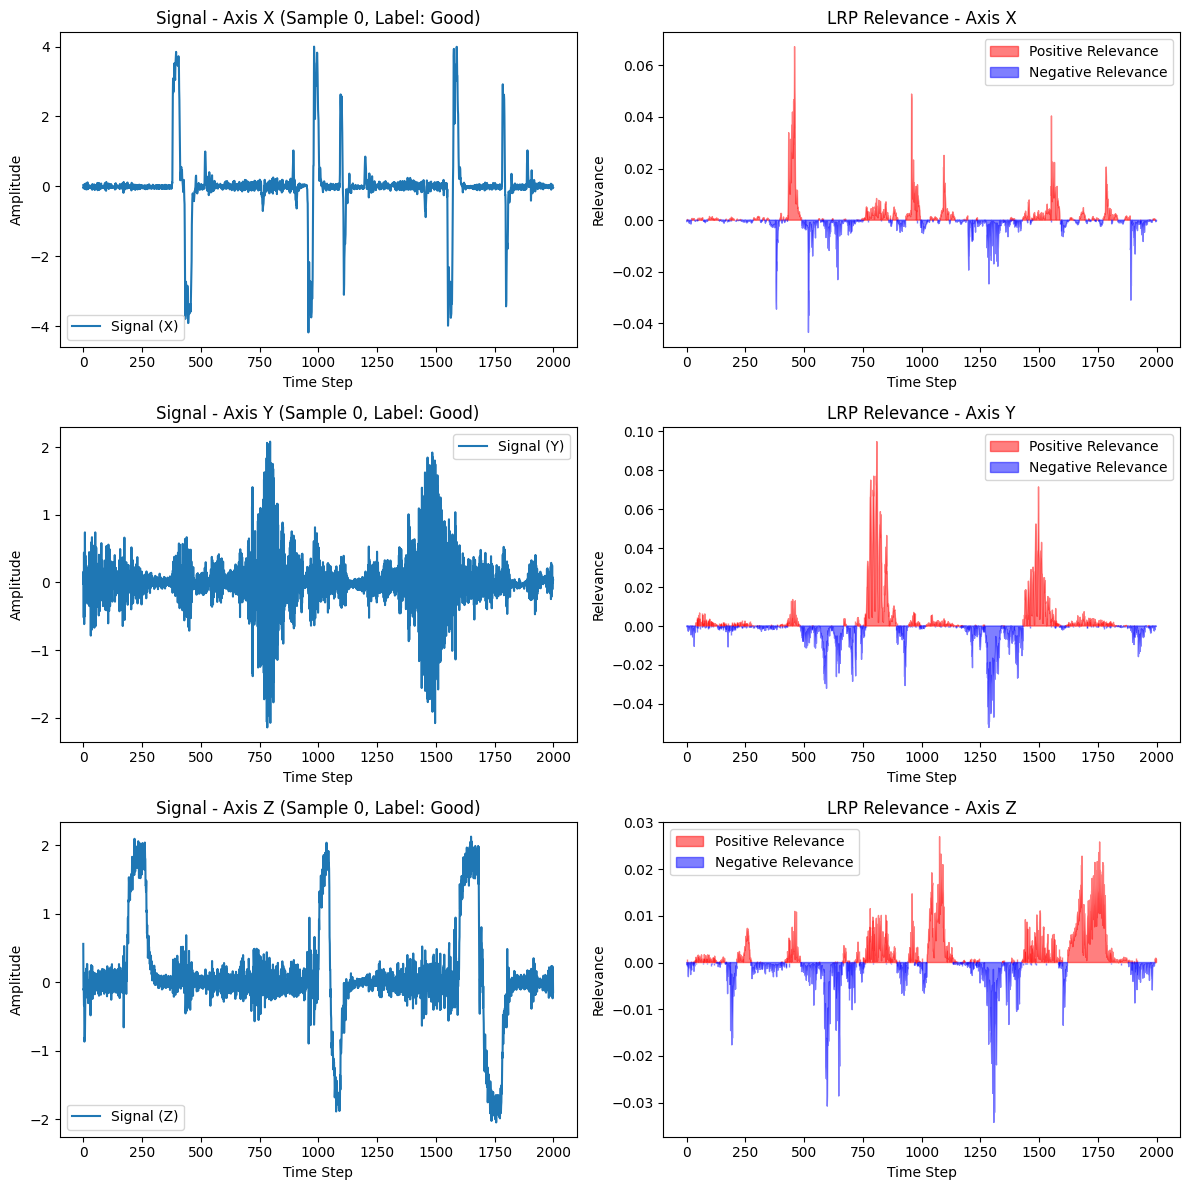

In [20]:
relevance, input_signal, final_label = compute_lrp_relevance(
    model=freq_model,
    sample=time_data.squeeze(0),  # Shape: (3, 10000) or torch tensor
    label=label,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index} Label: {'Good' if final_label == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal,
    relevance=relevance,
    label=final_label)

Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 69 Label: Good


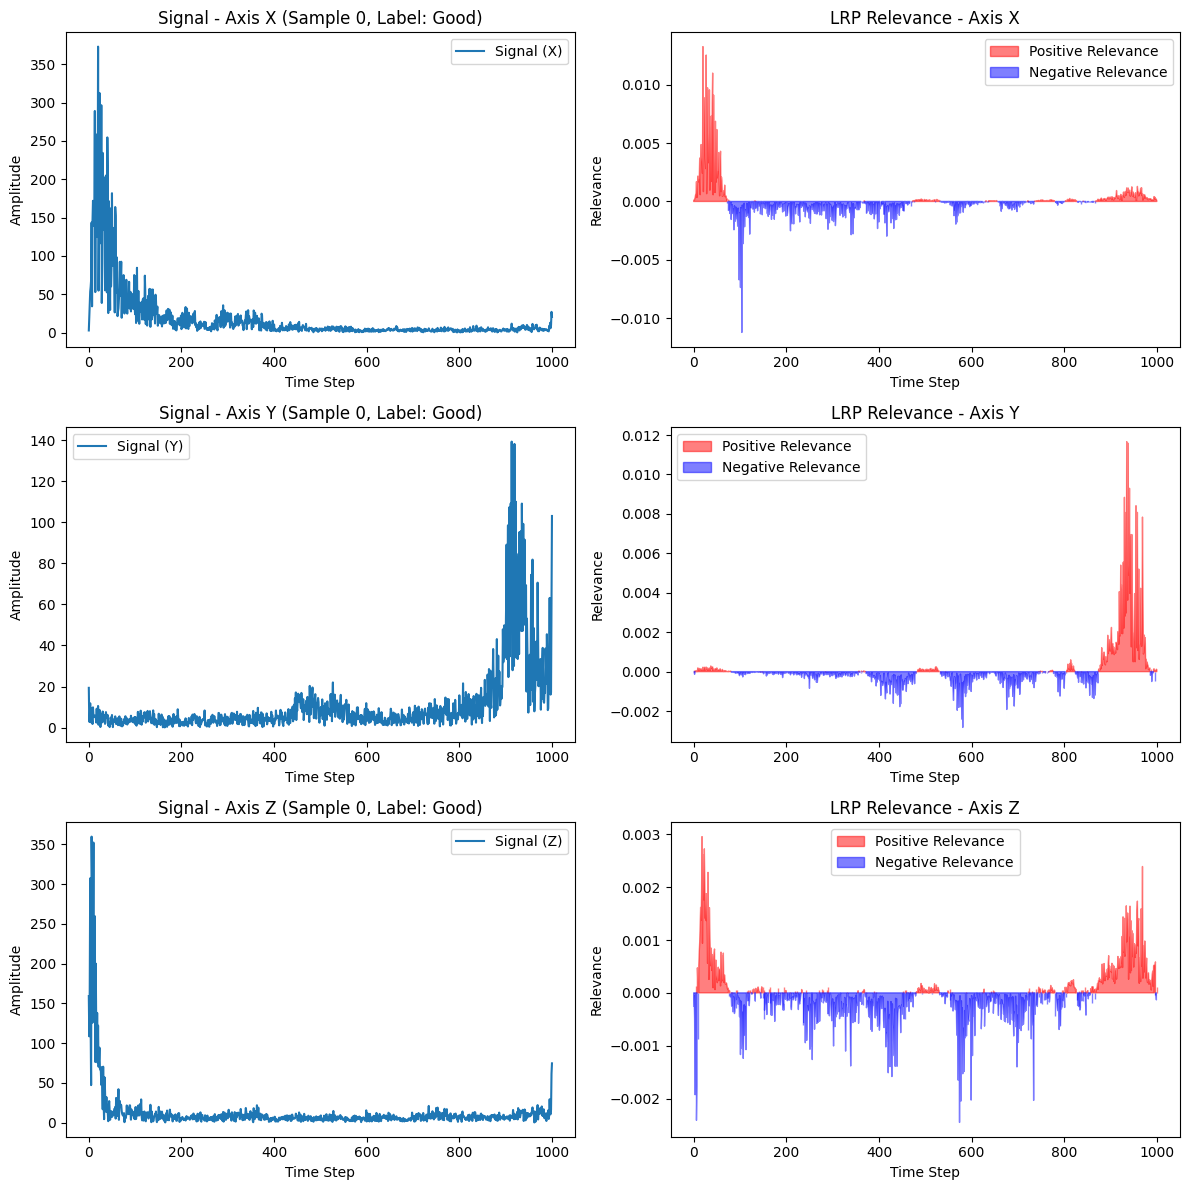

In [21]:
relevance, input_signal, final_label = compute_lrp_relevance(
    model=freq_model,
    sample=freq_data.squeeze(0),  # Shape: (3, 10000) or torch tensor
    label=label,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index} Label: {'Good' if final_label == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal,
    relevance=relevance,
    label=final_label)

#### DFT-LRP implementation

In [23]:
relevance_time, relevance_freq, signal_freq, input_signal, freqs, predicted_label = compute_dft_lrp_relevance(
        model=freq_model,
        sample=time_data.squeeze(0),  # Convert to NumPy for DFTLRP
        label=label.item(),
        device=device,
        signal_length=2000,   #10000 if we did not downsample
        sampling_rate=400  # Placeholder, replace with your actual sampling rate     #2000 if we did not downsample
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Input sample shape: torch.Size([1, 3, 2000])
Relevance time shape: (3, 2000)
Input signal shape: (3, 2000)
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Number of axis is: 3
Frequency length is:1001
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)


E:\Thesis\Datasets\CNC\utils\dft_lrp.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])


Min relevance: -0.05210327357053757, Max relevance: 0.09475796669721603
 Maximum Absolute Attribution in Axis 0: 0.06726489216089249
 Maximum Absolute Attribution in Axis 1: 0.09475796669721603
 Maximum Absolute Attribution in Axis 2: 0.03422911837697029


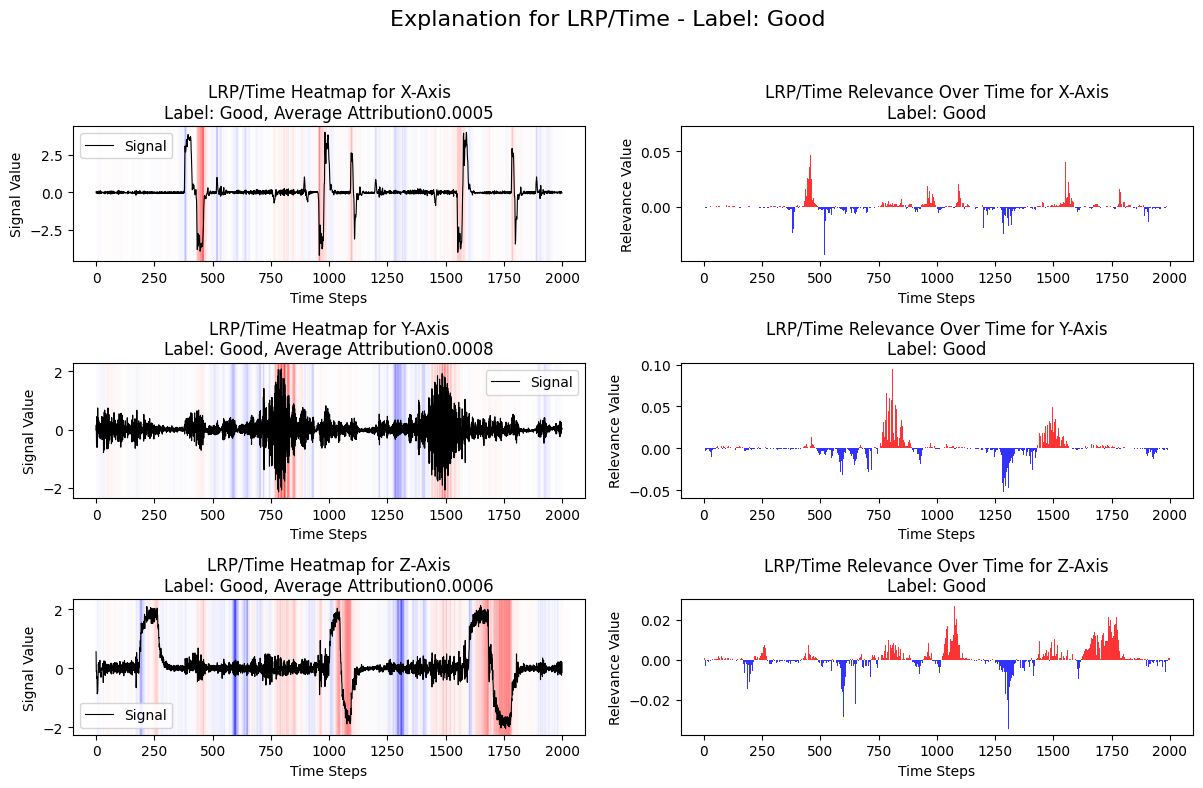

In [24]:
# LRP visualization with mutual visualization function
print(f"Min relevance: {np.min(relevance_time)}, Max relevance: {np.max(relevance_time)}")
visualize_with_label_attribution(time_data.squeeze(0), relevance_time, label, "LRP/Time")


In [11]:
""# Global Attribution over frequency with LRP
summary_lrp_freq = summarize_attributions(relevance_freq)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_freq = []
for axis, values in summary_lrp_freq.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_freq.append(row)

# Create the DataFrame
df_summary_lrp_freq = pd.DataFrame(data_lrp_freq)

# Display the DataFrame as a table
print(df_summary_lrp_freq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             508                 73.936548   
1  Axis 1             485                 10.040391   
2  Axis 2             496                 36.687105   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.145544             493                -74.359607   
1                    0.020702             516                 -6.190158   
2                    0.073966             505                -40.736601   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.150831                    -0.423059   
1                   -0.011996                     3.850233   
2                   -0.080667                    -4.049496   

   Average Relevance (Pos + Neg)  
0                      -0.000423  
1                       0.003846  
2                      -0.004045  


In [12]:
""# Global Attribution over frequency with LRP
summary_lrp_t = summarize_attributions(relevance_time)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_t = []
for axis, values in summary_lrp_t.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_t.append(row)

# Create the DataFrame
df_summary_lrp_t = pd.DataFrame(data_lrp_t)

# Display the DataFrame as a table
print(df_summary_lrp_t)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1027                  1.532312   
1  Axis 1            1207                  5.453089   
2  Axis 2            1014                  2.297824   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.001492             973                 -1.960022   
1                    0.004518             793                 -1.596478   
2                    0.002266             986                 -6.439903   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.002014                    -0.427710   
1                   -0.002013                     3.856612   
2                   -0.006531                    -4.142079   

   Average Relevance (Pos + Neg)  
0                      -0.000214  
1                       0.001928  
2                      -0.002071  


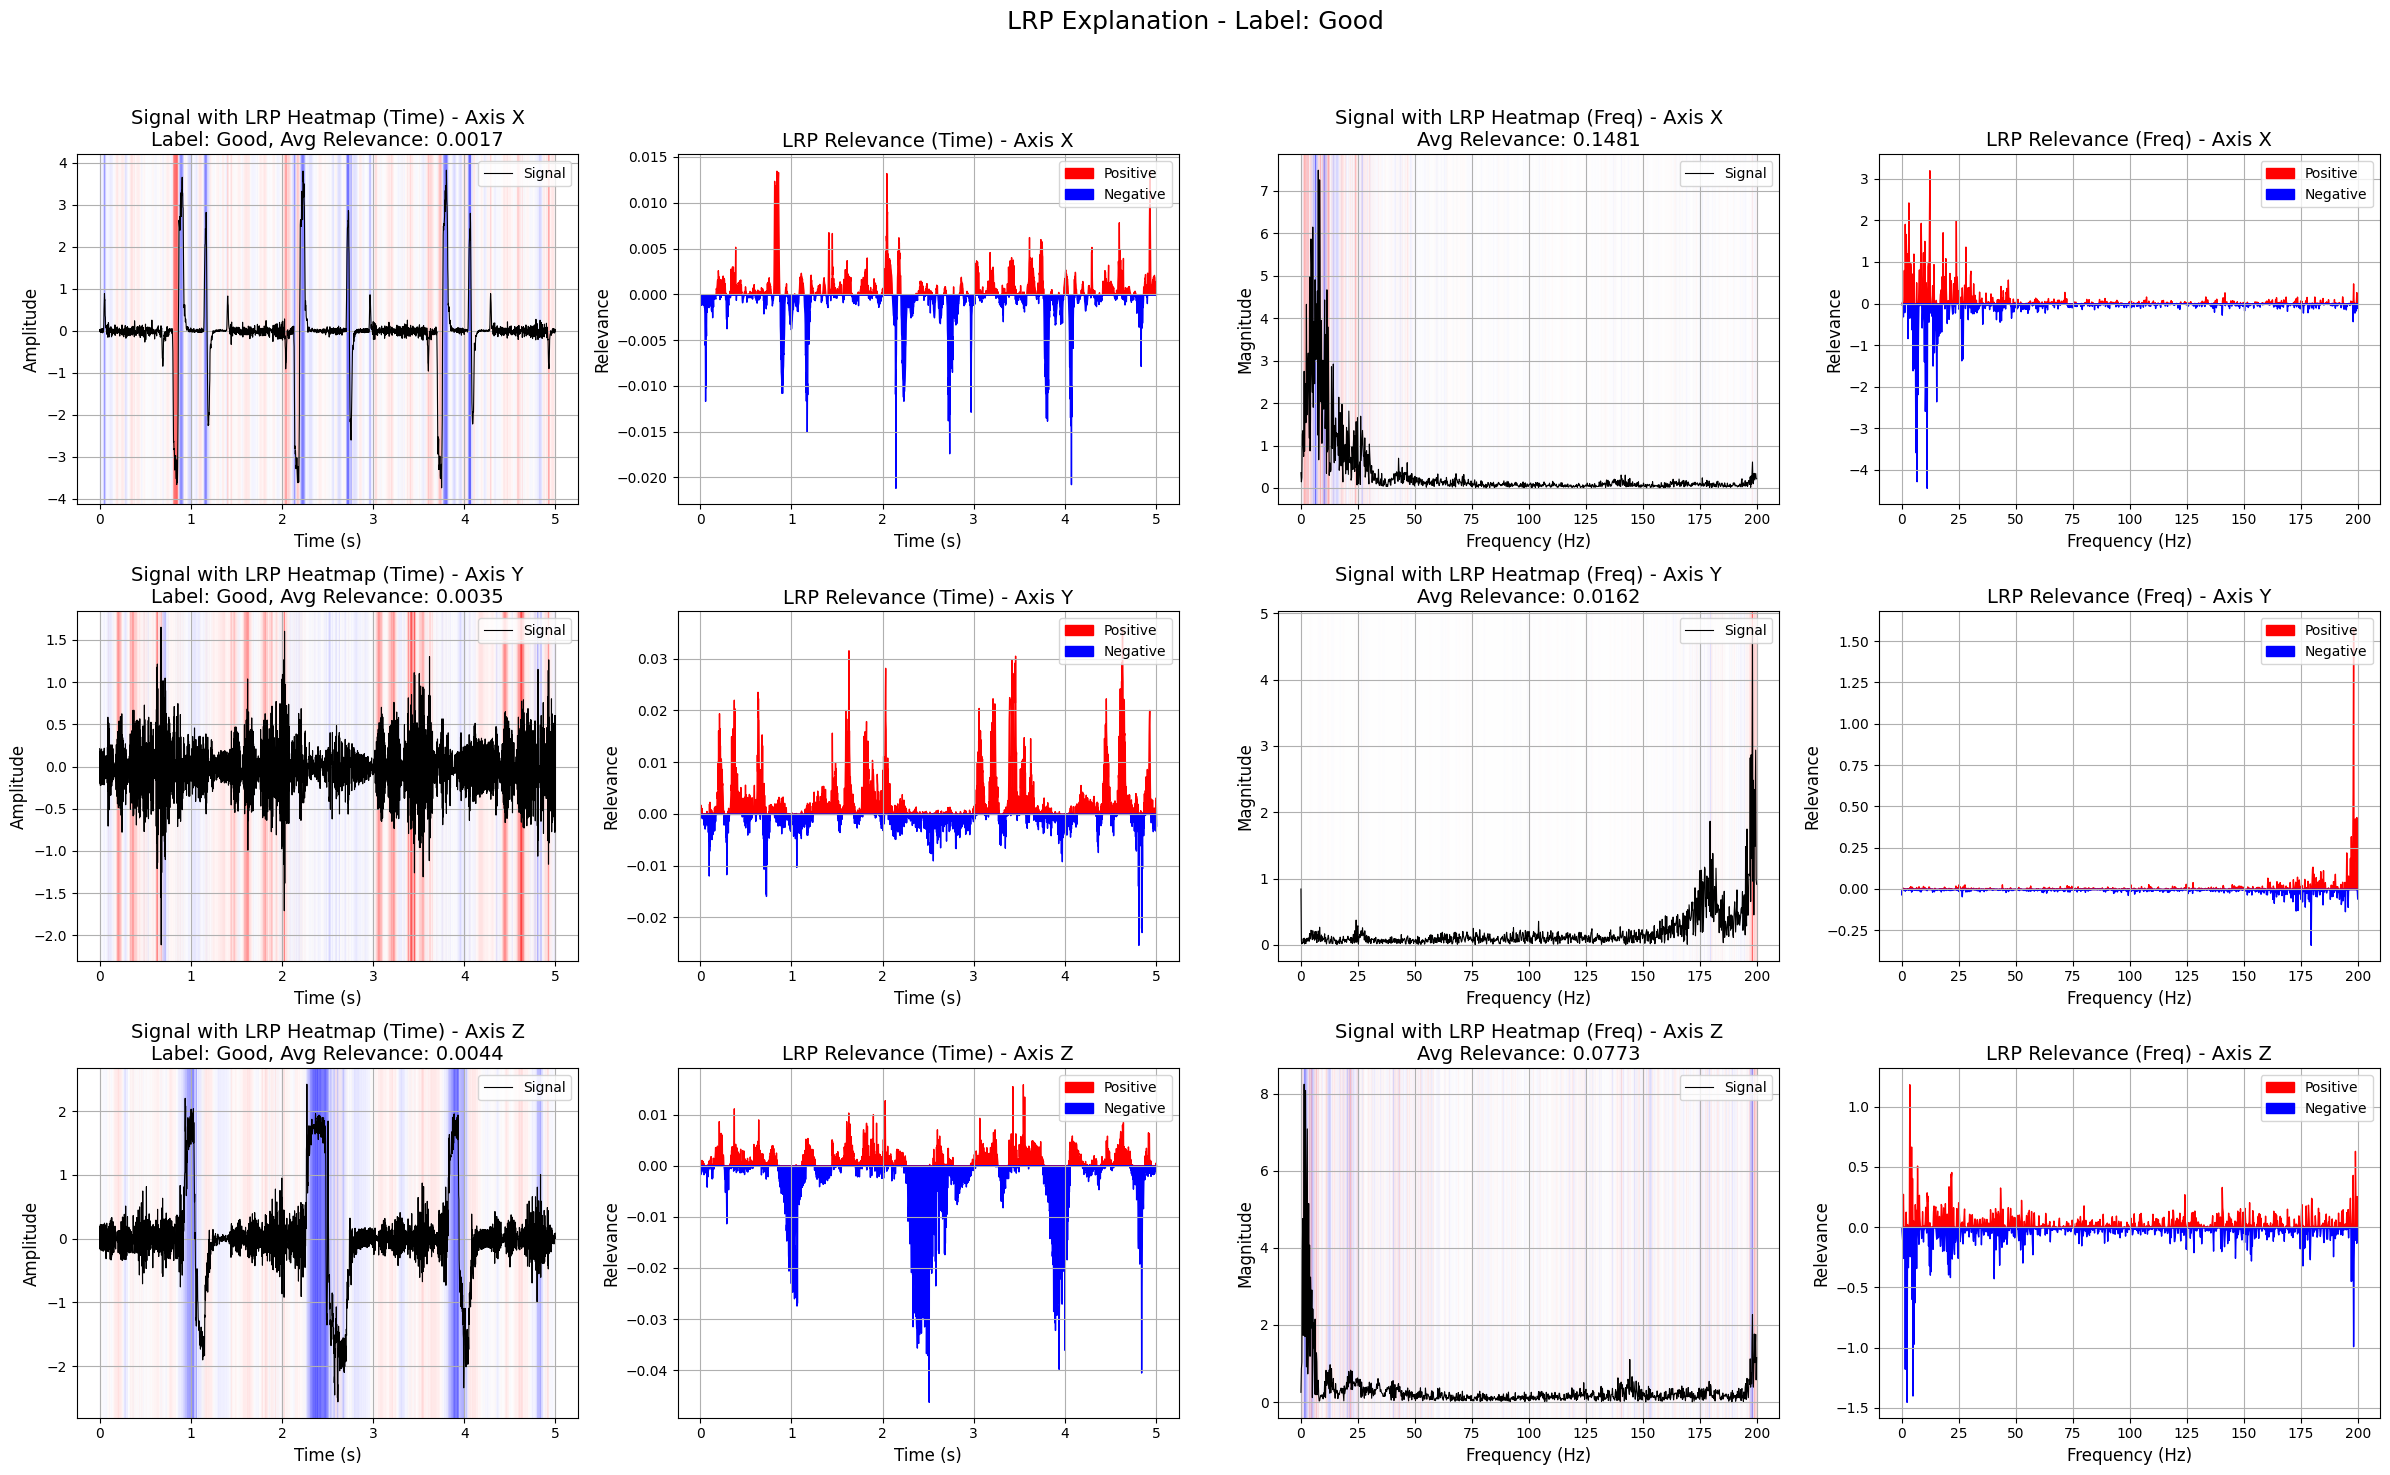

In [13]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time,
        relevance_freq=relevance_freq,
        signal_freq=signal_freq,
        input_signal=input_signal,
        freqs=freqs,
        predicted_label=predicted_label,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [14]:
# LRP visualization with common visualization function
 # write something similar to the common visualization for the frequency, so the relevance are colored over fft/dft signals
# in compute_dft_lrp_relevance why freqs are calculated by fft not dft?

In [ ]:
# feature_layer = layer_names[len(layer_names)//2]  # Pick a middle layer
# Get the number of channels in that layer
# num_channels = get_layer_channels(model, feature_layer)
# conditions = [{feature_layer: list(range(num_channels)), "y": [target_label]}]

In [25]:
relevance_time_fft, relevance_freq_fft, signal_freq_fft, relevance_timefreq_fft, signal_timefreq_fft, input_signal_fft, freqs_fft, predicted_label_fft = compute_fft_lrp_relevance(
        model=freq_model,
        sample=time_data.squeeze(0),
        label=None,
        signal_length=2000,
        sampling_rate=400,
        compute_timefreq=True,
        window_shift=50,  # Increased to reduce memory usage
        window_width=100,
        window_shape="rectangle"
    )

Input sample shape: torch.Size([1, 3, 2000])
Target label: 0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
relevance_time_tensor shape before squeeze: (1, 3, 2000)
relevance_time shape after squeeze: (3, 2000)
input_signal shape: (3, 2000)
fft_lrp: Input relevance shape = (1, 2000), signal shape = (1, 2000)
fft_lrp: relevance_tensor shape = torch.Size([1, 2000]), signal_tensor shape = torch.Size([1, 2000])
fourier_transform: signal_tensor shape = torch.Size([1, 2000])
fourier_transform (FFT): signal_hat shape = torch.Size([1, 1001])
fft_lrp: signal_hat shape = torch.Size([1, 1001])
fft_lrp: relevance_normed shape = torch.Size([1, 2000])
fft_lrp: relevance_fft real part = tensor([[ 0.4438, -0.0413,  0.3269,  ..., -0.2887,  0.3912, -0.2207]],
       device='cuda:0')
fft_lrp: relevance_fft imag part = tensor([[ 0.0000,  0.0448, -0.1751,  ..., -0.2621,  0.2341,  0.0000]],
       device='cuda:0')
fft_lrp: relevance_hat real part before cpu = tensor([[

E:\Thesis\Datasets\CNC\utils\fft_lrp.py:24: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:308.)
  arr = torch.from_numpy(arr).to(dtype=self.dtype)


In [26]:
# Global Attribution for FFT_LRP over frequency
summary_fft_freq = summarize_attributions(relevance_freq_fft)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_freq = []
for axis, values in summary_fft_freq.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_freq.append(row)

# Create the DataFrame
df_summary_fft_freq = pd.DataFrame(data_fft_freq)

# Display the DataFrame as a table
print(df_summary_fft_freq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             487    108.464728+  0.000000j   
1  Axis 1             486     29.124294+  0.000000j   
2  Axis 2             503    126.093901+  0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          0.222720+0.000000j             514   -107.849388+  0.000000j   
1          0.059927+0.000000j             515    -30.341587+  0.000000j   
2          0.250684+0.000000j             498   -126.955746+  0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -0.209824+0.000000j           0.615340+0.000000j   
1         -0.058916+0.000000j          -1.217293+0.000000j   
2         -0.254931+0.000000j          -0.861845+0.000000j   

   Average Relevance (Pos + Neg)  
0             0.000615+0.000000j  
1            -0.001216+0.000000j  
2            -0.000861+0.000000j  


In [27]:
# Global Attribution for FFT_LRP over time frequency
summary_fft_timefreq = summarize_attributions(relevance_timefreq_fft)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_timefreq = []
for axis, values in summary_fft_timefreq.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_timefreq.append(row)

# Create the DataFrame
df_summary_fft_timefreq = pd.DataFrame(data_fft_timefreq)

# Display the DataFrame as a table
print(df_summary_fft_timefreq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            9481    178.425658+  0.000000j   
1  Axis 1            9737     89.524642+  0.000000j   
2  Axis 2            9202    117.176762+  0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          0.018819+0.000000j           10539   -199.224093+  0.000000j   
1          0.009194+0.000000j           10283   -102.192390+  0.000000j   
2          0.012734+0.000000j           10818   -123.924438+  0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -0.018904+0.000000j        -20.798435+ 0.000000j   
1         -0.009938+0.000000j        -12.667748+ 0.000000j   
2         -0.011455+0.000000j         -6.747676+ 0.000000j   

   Average Relevance (Pos + Neg)  
0            -0.001039+0.000000j  
1            -0.000633+0.000000j  
2            -0.000337+0.000000j  


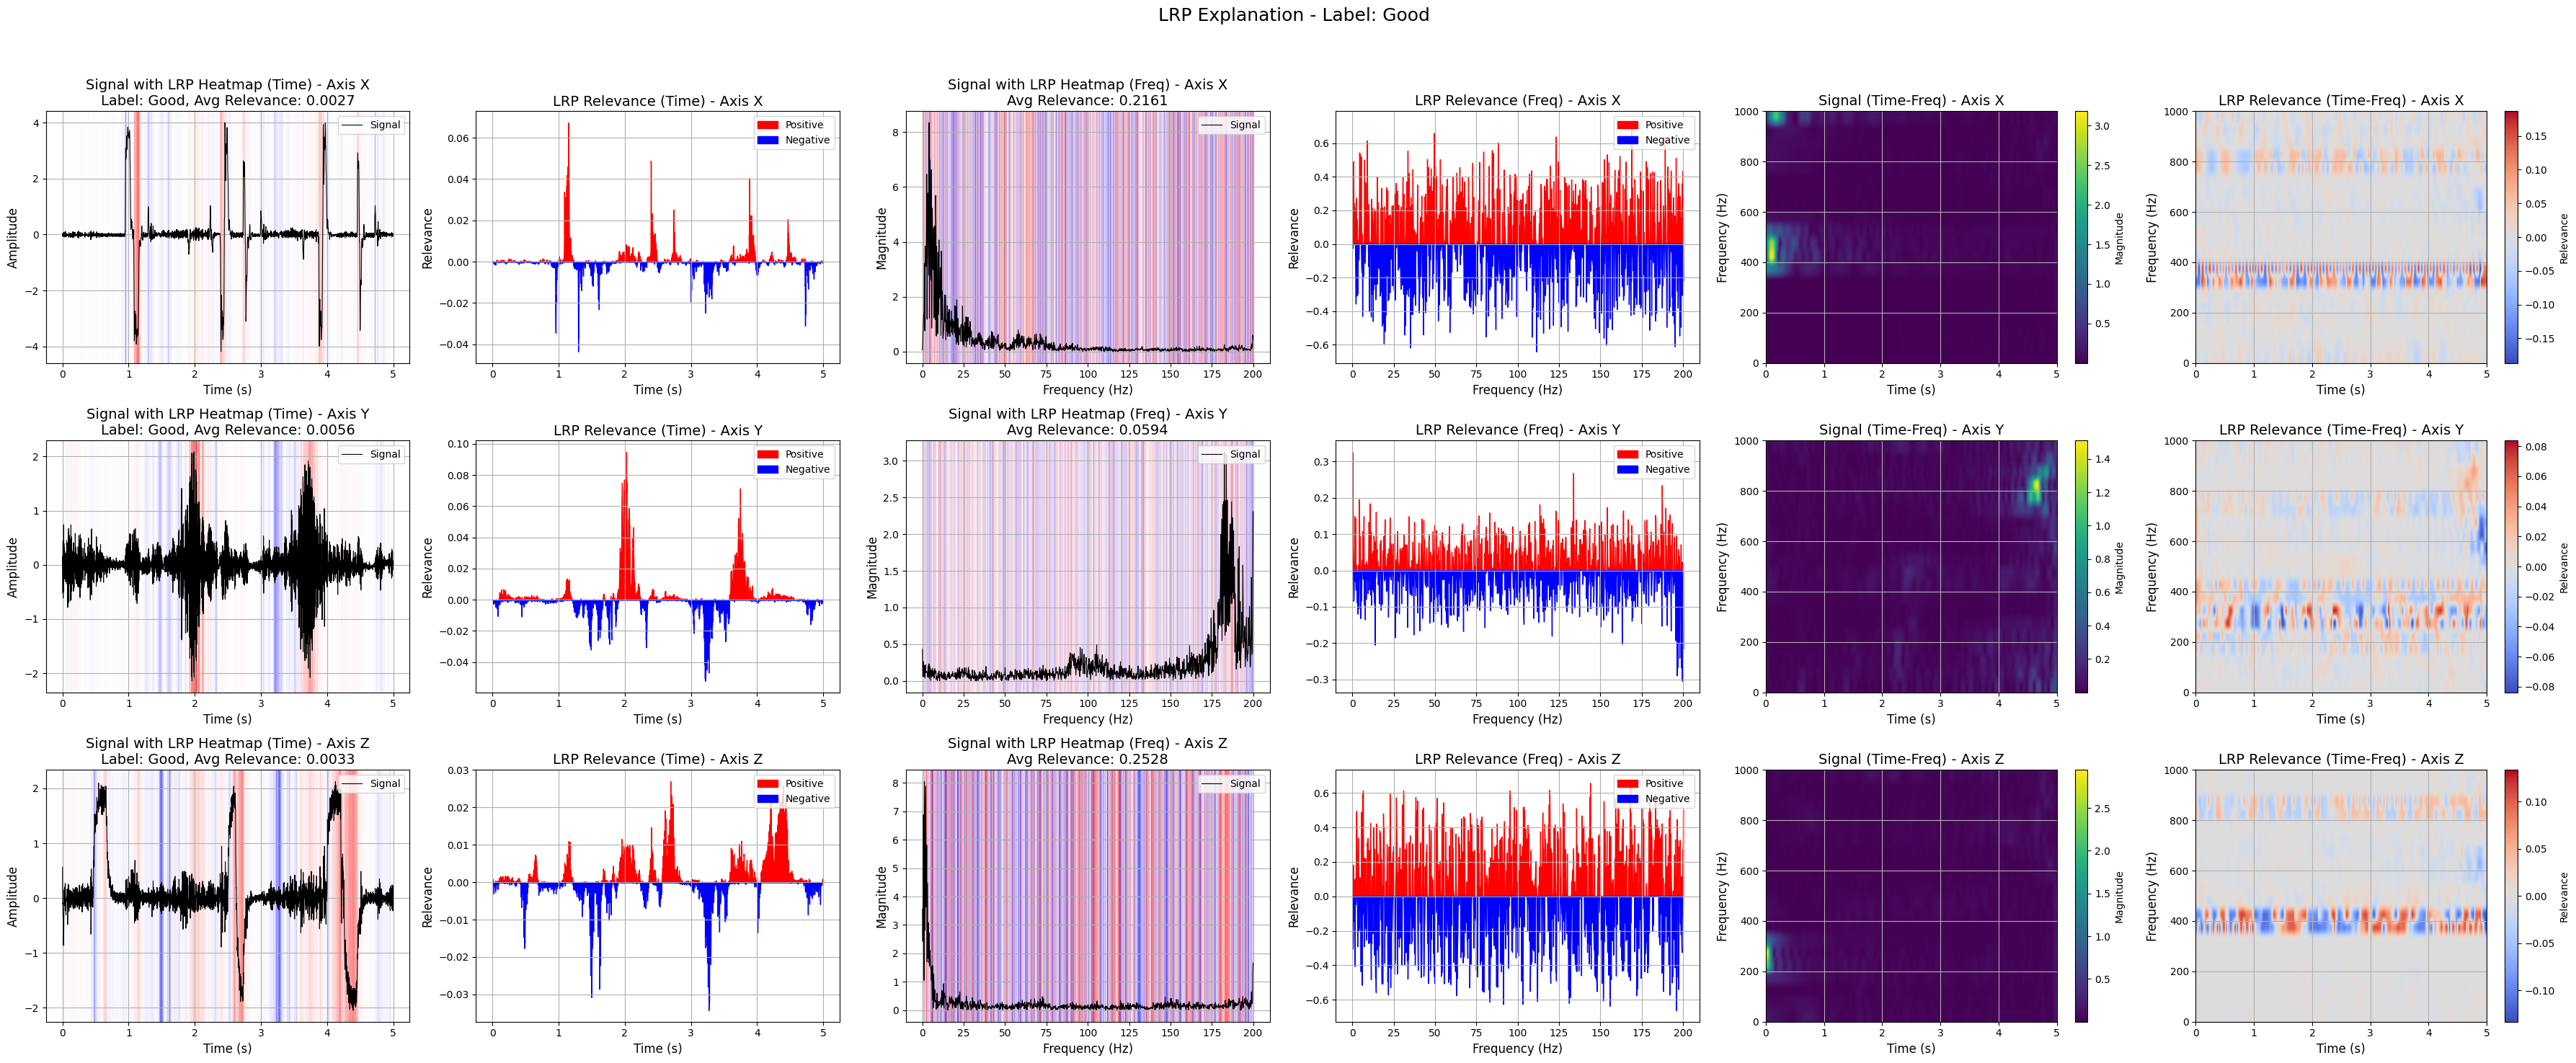

In [28]:
# Visualize
visualize_lrp_fft(
    relevance_time=relevance_time_fft,
    relevance_freq=relevance_freq_fft,
    signal_freq=signal_freq_fft,
    relevance_timefreq=relevance_timefreq_fft,
    signal_timefreq=signal_timefreq_fft,
    input_signal=input_signal_fft,
    freqs=freqs_fft,
    predicted_label=predicted_label_fft,
    signal_length=2000,
    sampling_rate=400,
    k_max=1000
)

#### FFT-LRP implementation?

Min relevance: -0.06843177229166031, Max relevance: 0.07588394731283188
 Maximum Absolute Attribution in Axis 0: 0.07588394731283188
 Maximum Absolute Attribution in Axis 1: 0.04665098711848259
 Maximum Absolute Attribution in Axis 2: 0.06843177229166031


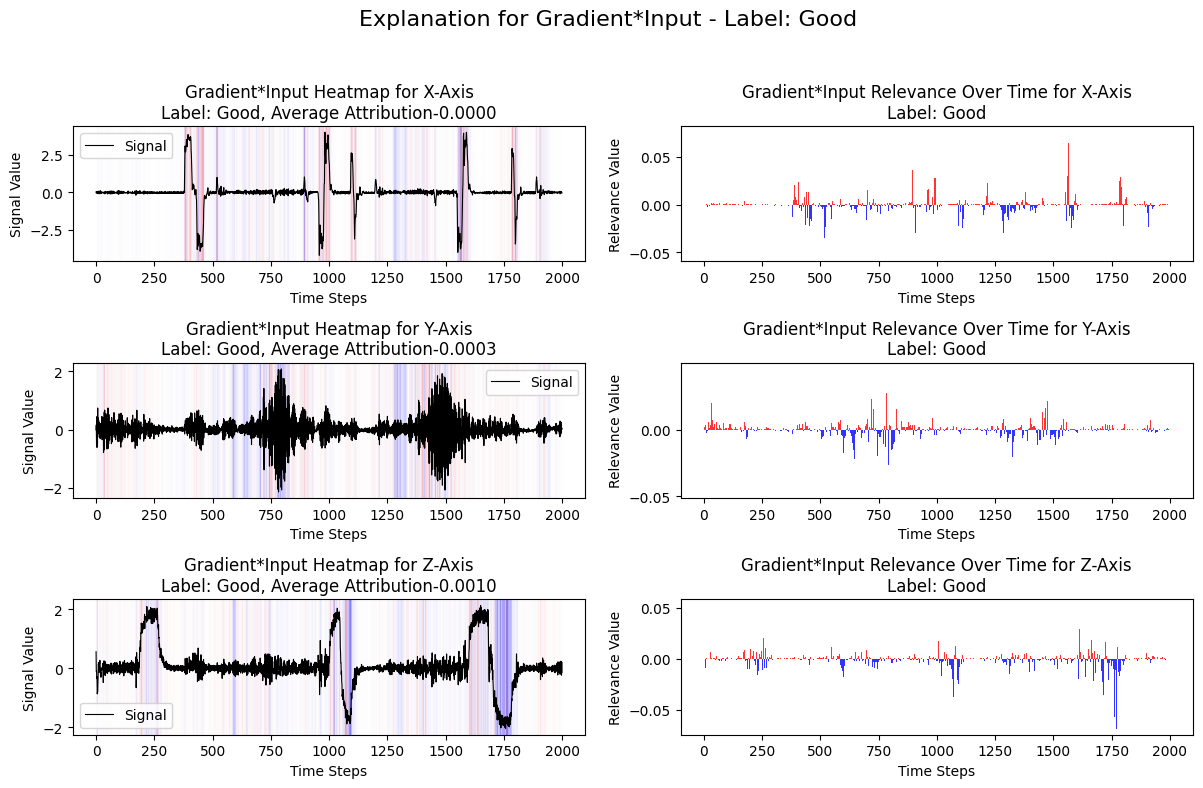

In [29]:
# Grad*Input
grad_input_attr, _ = grad_times_input_relevance(freq_model, time_data.squeeze(0))

print(f"Min relevance: {np.min(grad_input_attr.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(time_data.squeeze(0), grad_input_attr, label, "Gradient*Input")


In [30]:
# Example usage
summary_g = summarize_attributions(grad_input_attr.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_g = []
for axis, values in summary_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_g.append(row)

# Create the DataFrame
df_summary_g = pd.DataFrame(data_g)

# Display the DataFrame as a table
print(df_summary_g)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             951                  3.285653   
1  Axis 1            1034                  2.198678   
2  Axis 2             964                  2.472568   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.003455            1049                 -3.341207   
1                    0.002126             966                 -2.700600   
2                    0.002565            1036                 -4.566391   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.003185                    -0.055554   
1                   -0.002796                    -0.501922   
2                   -0.004408                    -2.093823   

   Average Relevance (Pos + Neg)  
0                      -0.000028  
1                      -0.000251  
2                      -0.001047  


Min relevance: -0.061885036528110504, Max relevance: 0.06503937393426895
 Maximum Absolute Attribution in Axis 0: 0.06503937393426895
 Maximum Absolute Attribution in Axis 1: 0.041799433529376984
 Maximum Absolute Attribution in Axis 2: 0.02989046275615692


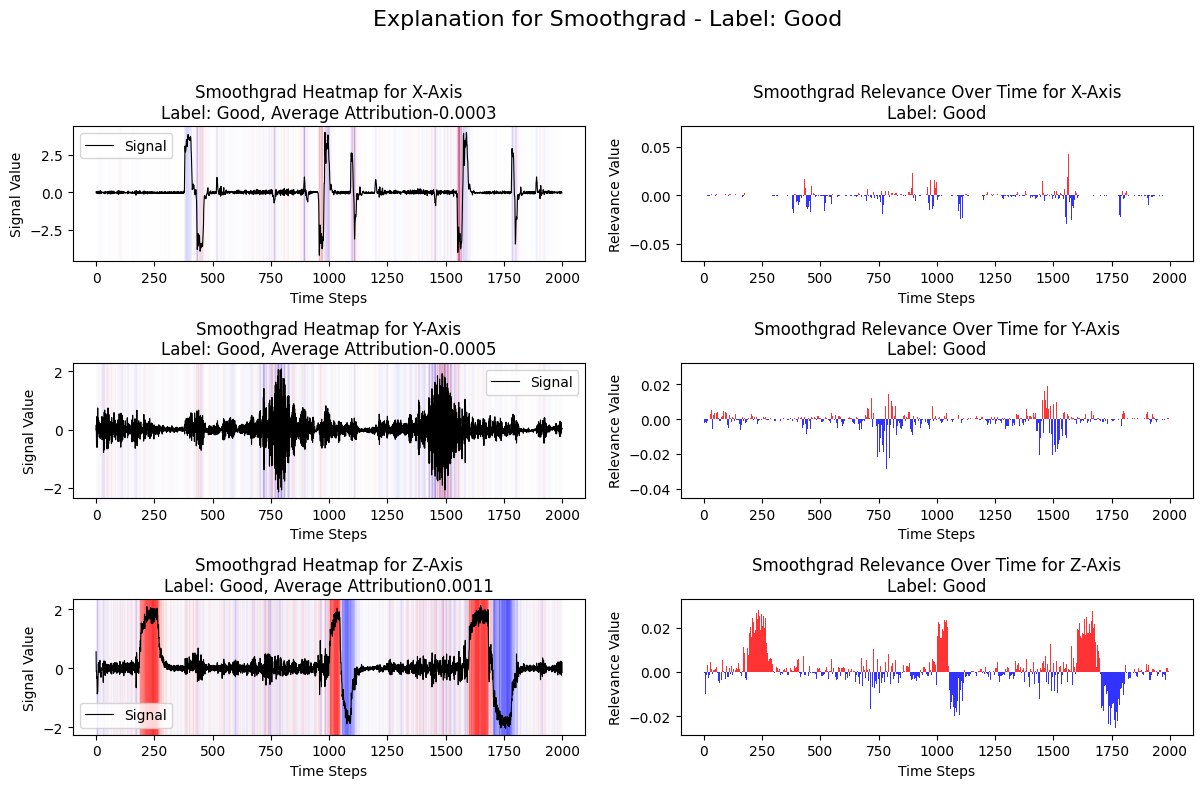

In [31]:

# SmoothGrad
smoothgrad_attr, _ = smoothgrad_relevance(freq_model, time_data.squeeze(0))
print(f"Min relevance: {np.min(smoothgrad_attr.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(time_data.squeeze(0), smoothgrad_attr, label, "Smoothgrad")


Min relevance: -0.01879262924194336, Max relevance: 0.03501701354980469
 Maximum Absolute Attribution in Axis 0: 0.03501701354980469
 Maximum Absolute Attribution in Axis 1: 0.012413263320922852
 Maximum Absolute Attribution in Axis 2: 0.0089569091796875


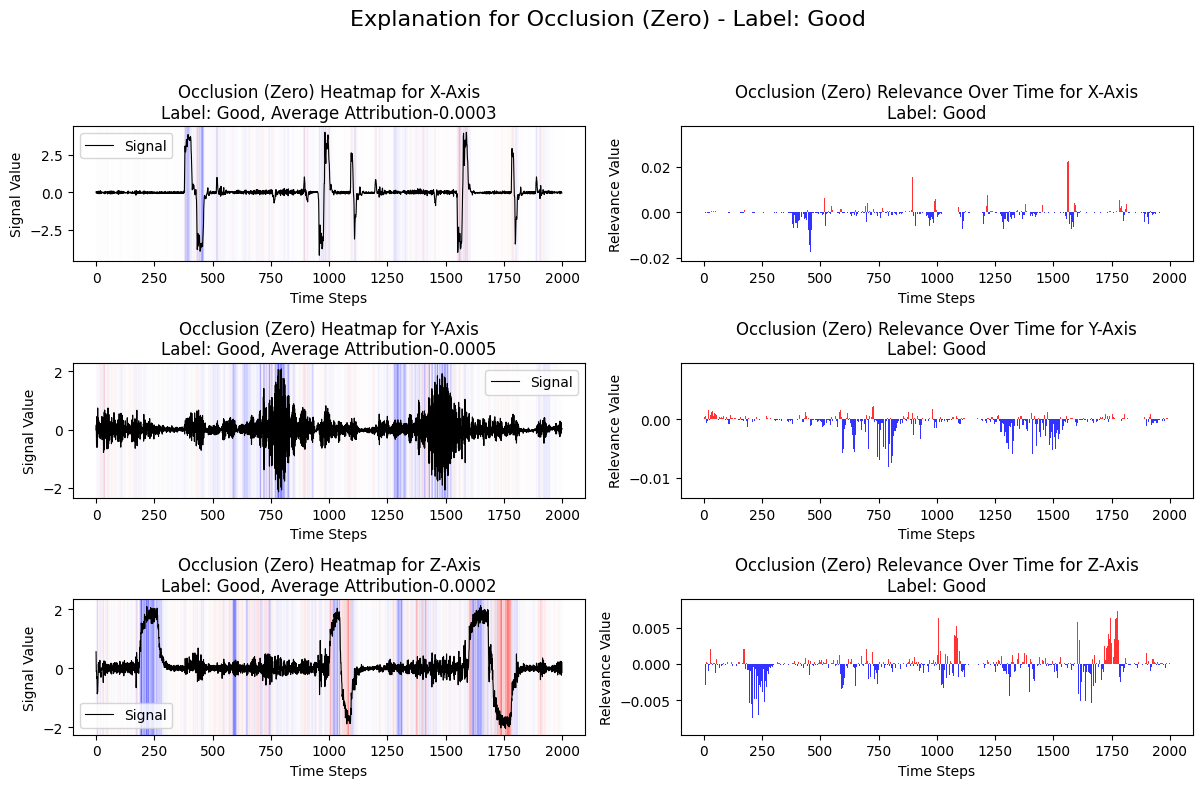

In [32]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero, _ = occlusion_signal_relevance(freq_model, time_data.squeeze(0), occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero.detach().cpu().numpy())}")
visualize_with_label_attribution(time_data.squeeze(0), occlusion_attr_zero, label, "Occlusion (Zero)")


Min relevance: -0.10589027404785156, Max relevance: 0.037021636962890625
 Maximum Absolute Attribution in Axis 0: 0.10589027404785156
 Maximum Absolute Attribution in Axis 1: 0.10589027404785156
 Maximum Absolute Attribution in Axis 2: 0.10589027404785156


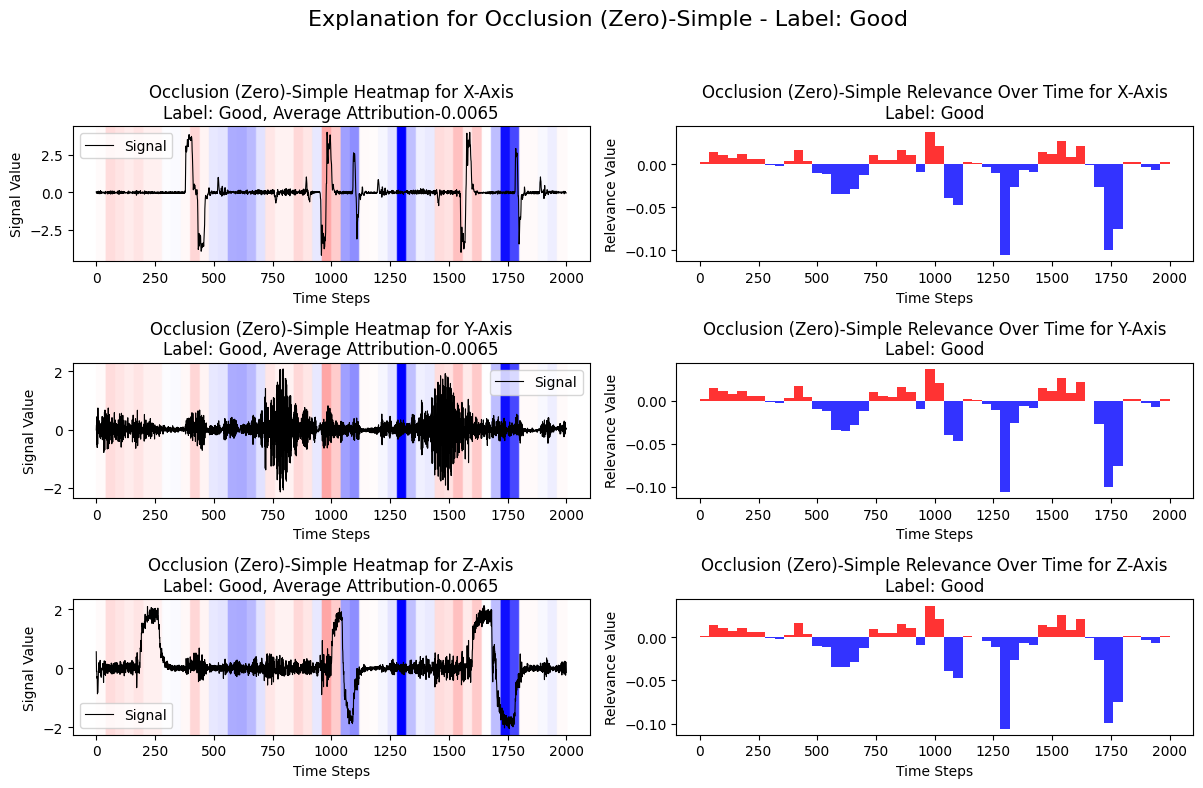

In [33]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(freq_model, time_data.squeeze(0), occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(time_data.squeeze(0), occlusion_attr_zero_simple, label, "Occlusion (Zero)-Simple")


Min relevance: -0.08587789535522461, Max relevance: 0.22395110130310059
 Maximum Absolute Attribution in Axis 0: 0.22395110130310059
 Maximum Absolute Attribution in Axis 1: 0.22395110130310059
 Maximum Absolute Attribution in Axis 2: 0.22395110130310059


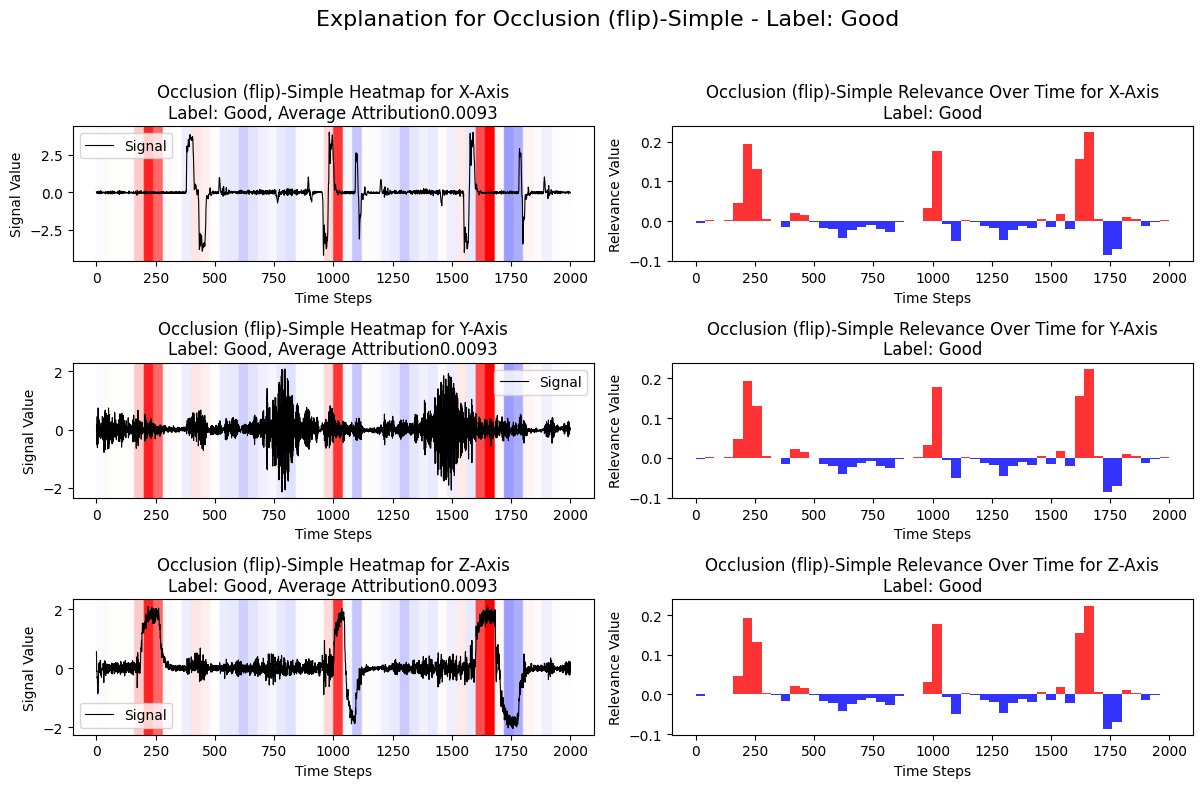

In [34]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(freq_model, time_data.squeeze(0), occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(time_data.squeeze(0), occlusion_attr_zero_simple, label, "Occlusion (flip)-Simple")


Min relevance: -0.04056906700134277, Max relevance: 0.05175065994262695
 Maximum Absolute Attribution in Axis 0: 0.05175065994262695
 Maximum Absolute Attribution in Axis 1: 0.032396554946899414
 Maximum Absolute Attribution in Axis 2: 0.04056906700134277


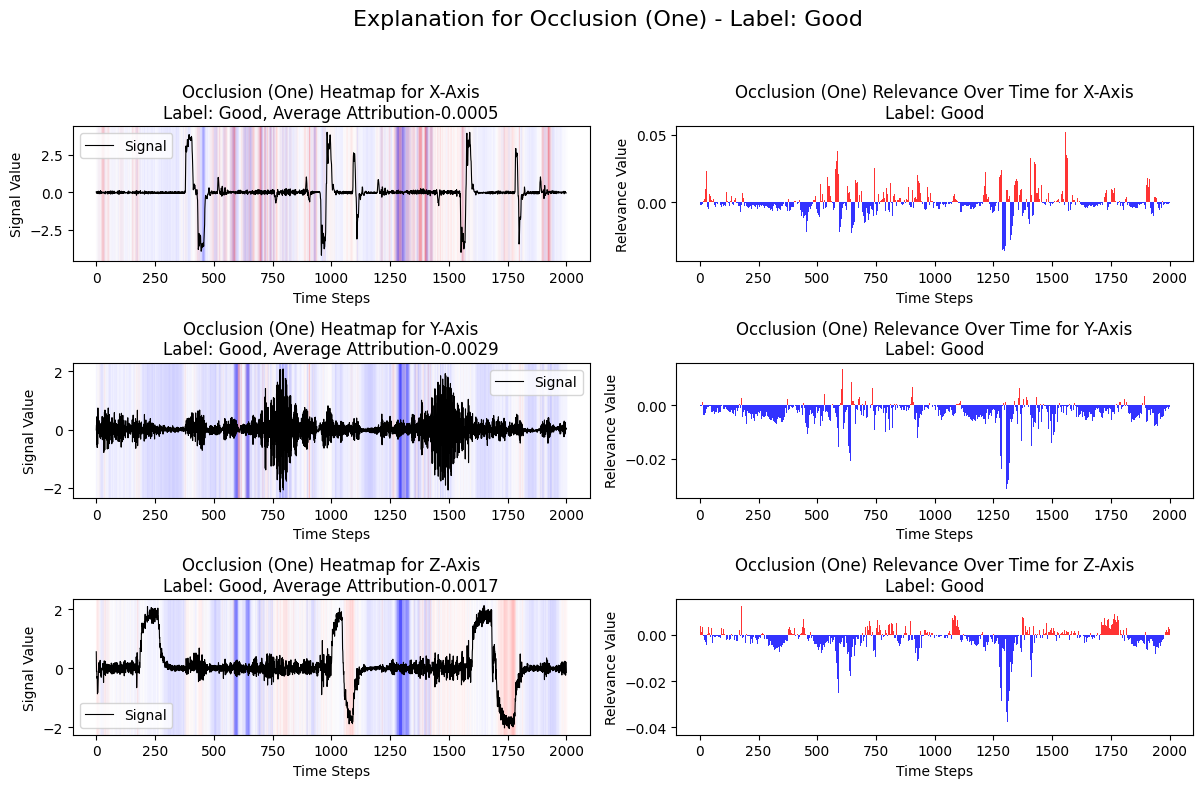

In [35]:
# Occlusion (one occlusion)
occlusion_attr_one, _ = occlusion_signal_relevance(freq_model, time_data.squeeze(0), occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one.detach().cpu().numpy())}")
visualize_with_label_attribution(time_data.squeeze(0), occlusion_attr_one, label, "Occlusion (One)")


Min relevance: -0.053305625915527344, Max relevance: 0.05375051498413086
 Maximum Absolute Attribution in Axis 0: 0.05375051498413086
 Maximum Absolute Attribution in Axis 1: 0.04736638069152832
 Maximum Absolute Attribution in Axis 2: 0.0379793643951416


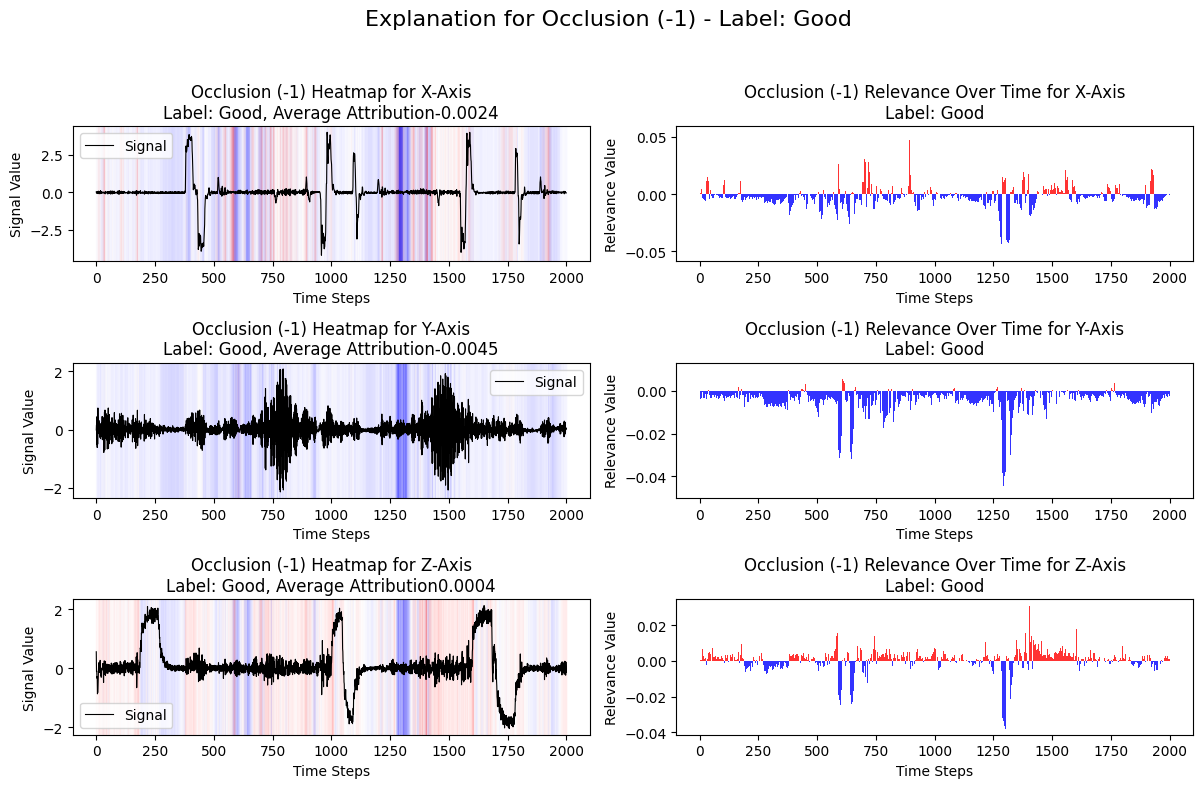

In [36]:
# Occlusion (-one occlusion)
occlusion_attr_mone, _ = occlusion_signal_relevance(freq_model, time_data.squeeze(0), occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone.detach().cpu().numpy())}")
visualize_with_label_attribution(time_data.squeeze(0), occlusion_attr_mone, label, "Occlusion (-1)")


Min relevance: -0.030839920043945312, Max relevance: 0.09540796279907227
 Maximum Absolute Attribution in Axis 0: 0.09540796279907227
 Maximum Absolute Attribution in Axis 1: 0.030839920043945312
 Maximum Absolute Attribution in Axis 2: 0.02030491828918457


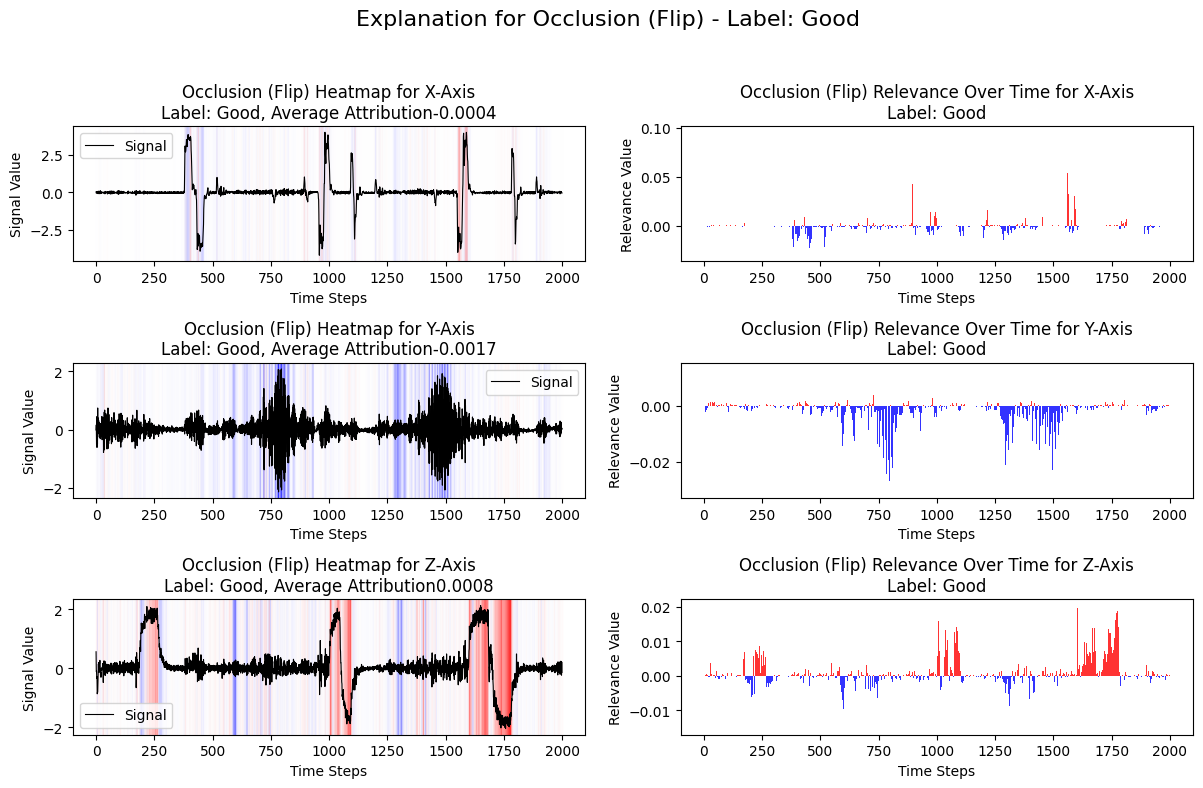

In [37]:
# Occlusion (flip occlusion)
occlusion_attr_flip, _ = occlusion_signal_relevance(freq_model, time_data.squeeze(0), occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip.detach().cpu().numpy())}")

visualize_with_label_attribution(time_data.squeeze(0), occlusion_attr_flip, label, "Occlusion (Flip)")


In [38]:
# Load a Bad sample

# Load a batch
sample_batch, label_batch = next(iter(train_loader))

random.seed(44)
# Choose a random index
random_index_b = random.randint(0, len(sample_batch) - 1)

# Select the random sample and its corresponding label
sample_b = sample_batch[random_index_b]  # Shape: (3, 10000)
label_b = label_batch[random_index_b]    # Shape: ()



sample_b = sample_b.to(device)
label_b = label_b.to(device)

_, predicted_label_b = predict_single(freq_model, sample_b)


# Print the selected sample and label
print(f"Random Index: {random_index_b}, Predicted_label:{predicted_label_b}, True_label:{label_b}")
print(sample_b,sample_b.shape)


RuntimeError: shape '[1, 3, 1001]' is invalid for input of size 384384

In [92]:

# Choose a random index
random.seed(10)
sample_batch_b, label_batch_b = next(iter(train_loader))
random_index_b = random.randint(0, len(sample_batch_b[1]) - 1)

# Get a single sample using your dataset's __getitem__ method
sample_idx_b = random_index_b  # Your selected index
data_tuple_b, label_b = dataset[sample_idx_b]  # This gives ((time_data, freq_data), label)

# Unpack the data tuple
time_data_b, freq_data_b = data_tuple_b

# Add batch dimension and move to device
time_data_b = time_data_b.unsqueeze(0).to(device)
freq_data_b = freq_data_b.unsqueeze(0).to(device)
label_b = torch.tensor([label_b]).to(device)

# Make prediction
with torch.no_grad():
    # Pass both time and frequency data to the model
    # This depends on how your model's forward method is implemented
    output_b = freq_model((time_data_b, freq_data_b))
    _, predicted_label_b = torch.max(output_b, 1)

print(f"Random Index: {sample_idx_b}, Predicted_label:{predicted_label_b.item()}, True_label:{label_b.item()}, Sample_time_shape:{time_data_b.shape}, Sample_freq_shape:{freq_data_b.shape}, lable_shape:{label_b.shape}")


Random Index: 8, Predicted_label:0, True_label:0, Sample_time_shape:torch.Size([1, 3, 2000]), Sample_freq_shape:torch.Size([1, 3, 1001]), lable_shape:torch.Size([1])


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 28 Label: Bad


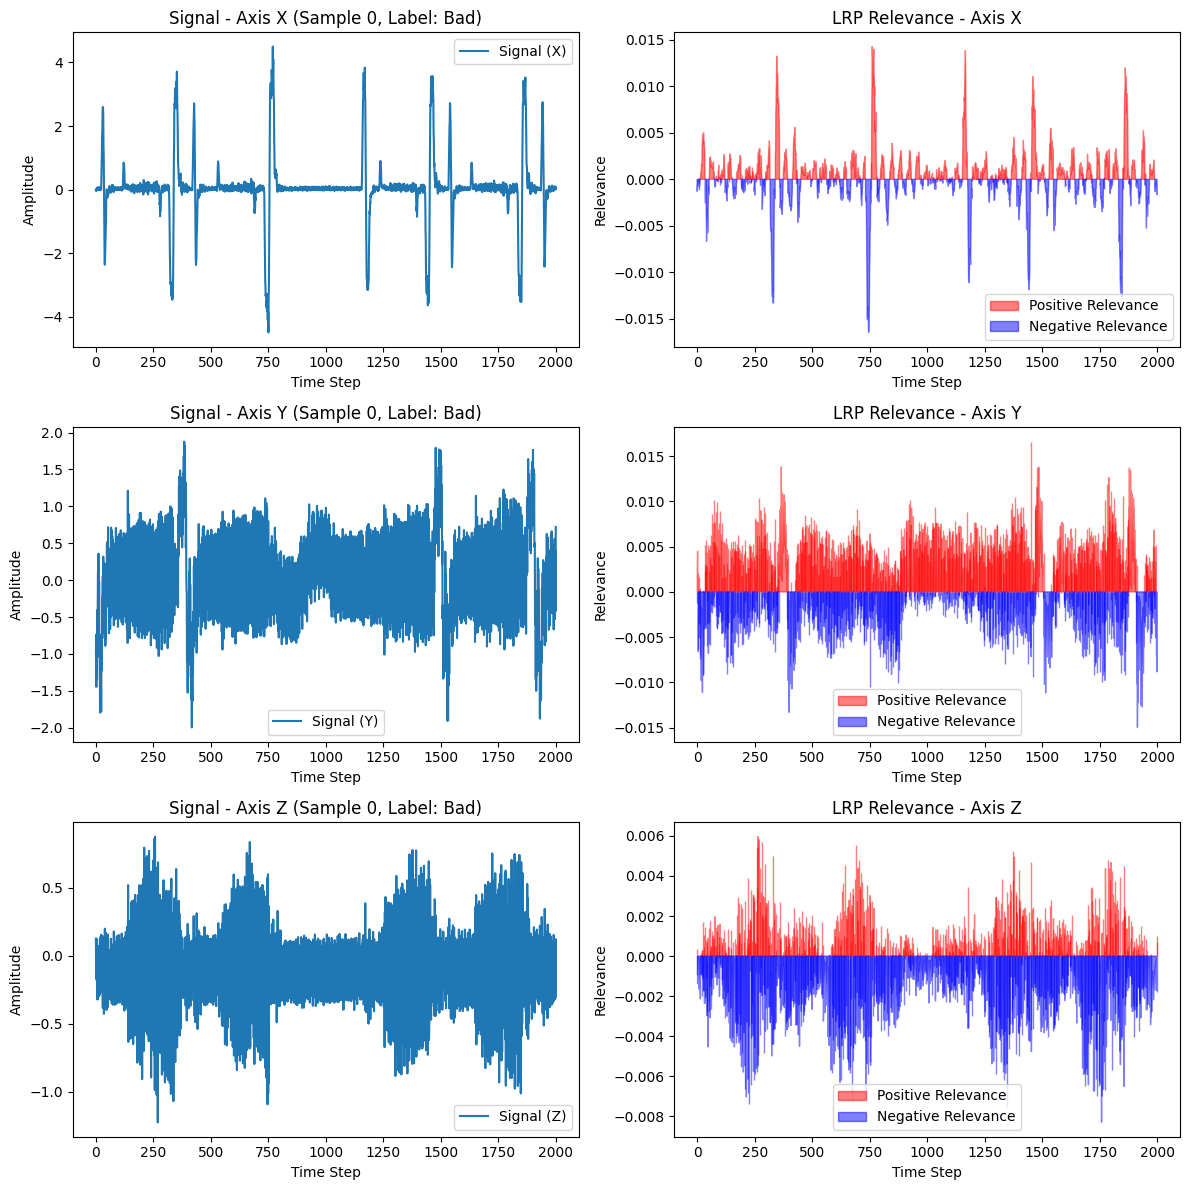

In [51]:
relevance_b, input_signal_b, final_label_b = compute_lrp_relevance(
    model=freq_model,
    sample=sample_b,  # Shape: (3, 10000) or torch tensor
    label=label_b,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index} Label: {'Good' if final_label_b == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal_b,
    relevance=relevance_b,
    label=final_label_b)

Min relevance: -0.07882195711135864, Max relevance: 0.08806973695755005
 Maximum Absolute Attribution in Axis 0: 0.08806973695755005
 Maximum Absolute Attribution in Axis 1: 0.07880678027868271
 Maximum Absolute Attribution in Axis 2: 0.052968692034482956


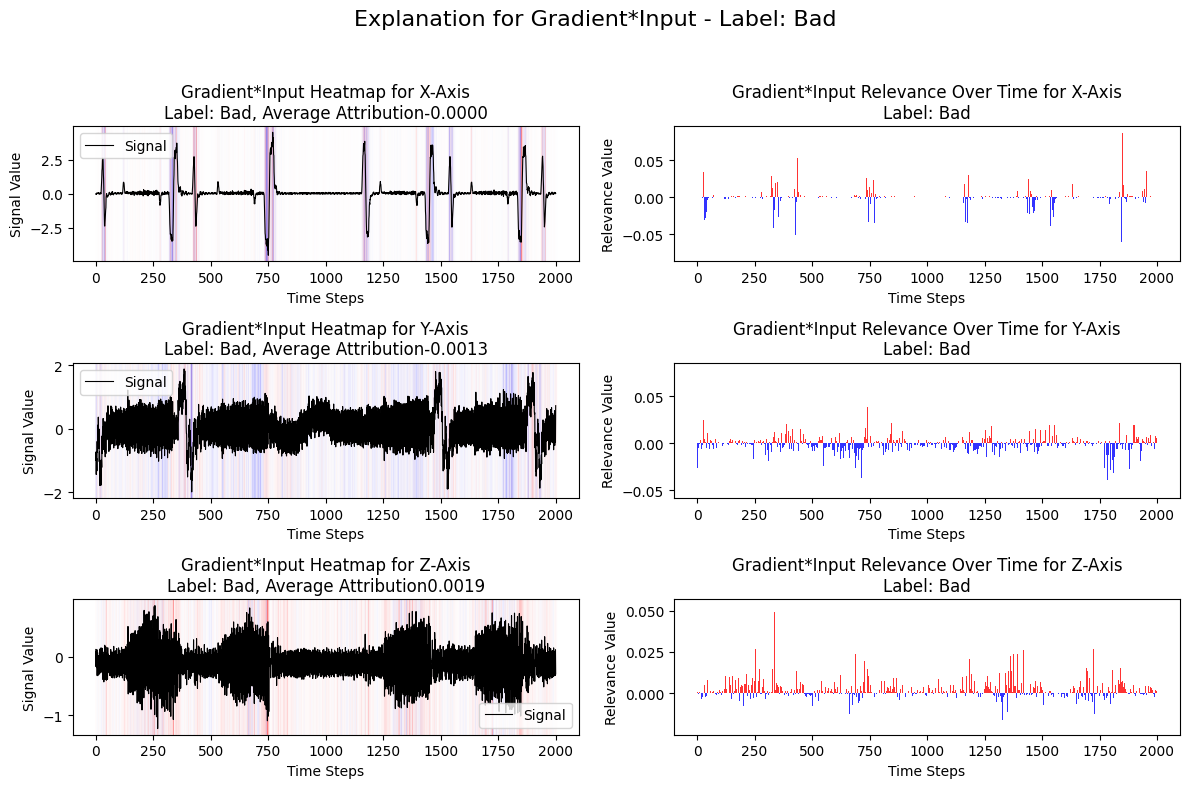

In [52]:
# Grad*Input
grad_input_attr_b, _ = grad_times_input_relevance(freq_model, sample_b)
print(f"Min relevance: {np.min(grad_input_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, grad_input_attr_b, label_b, "Gradient*Input")

In [53]:
# Example usage
summary_b_g = summarize_attributions(grad_input_attr_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_b_g = []
for axis, values in summary_b_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_g.append(row)

# Create the DataFrame
df_summary_b_g = pd.DataFrame(data_b_g)

# Display the DataFrame as a table
print(df_summary_b_g)


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1077                  3.278661   
1  Axis 1             872                  4.089097   
2  Axis 2            1284                  5.202026   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.003044             923                 -3.359612   
1                    0.004689            1128                 -6.639393   
2                    0.004051             716                 -1.495448   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.003640                    -0.080951   
1                   -0.005886                    -2.550296   
2                   -0.002089                     3.706578   

   Average Relevance (Pos + Neg)  
0                      -0.000040  
1                      -0.001275  
2                       0.001853  


Min relevance: -0.12931321561336517, Max relevance: 0.04380234703421593
 Maximum Absolute Attribution in Axis 0: 0.12931321561336517
 Maximum Absolute Attribution in Axis 1: 0.04380234703421593
 Maximum Absolute Attribution in Axis 2: 0.04209531098604202


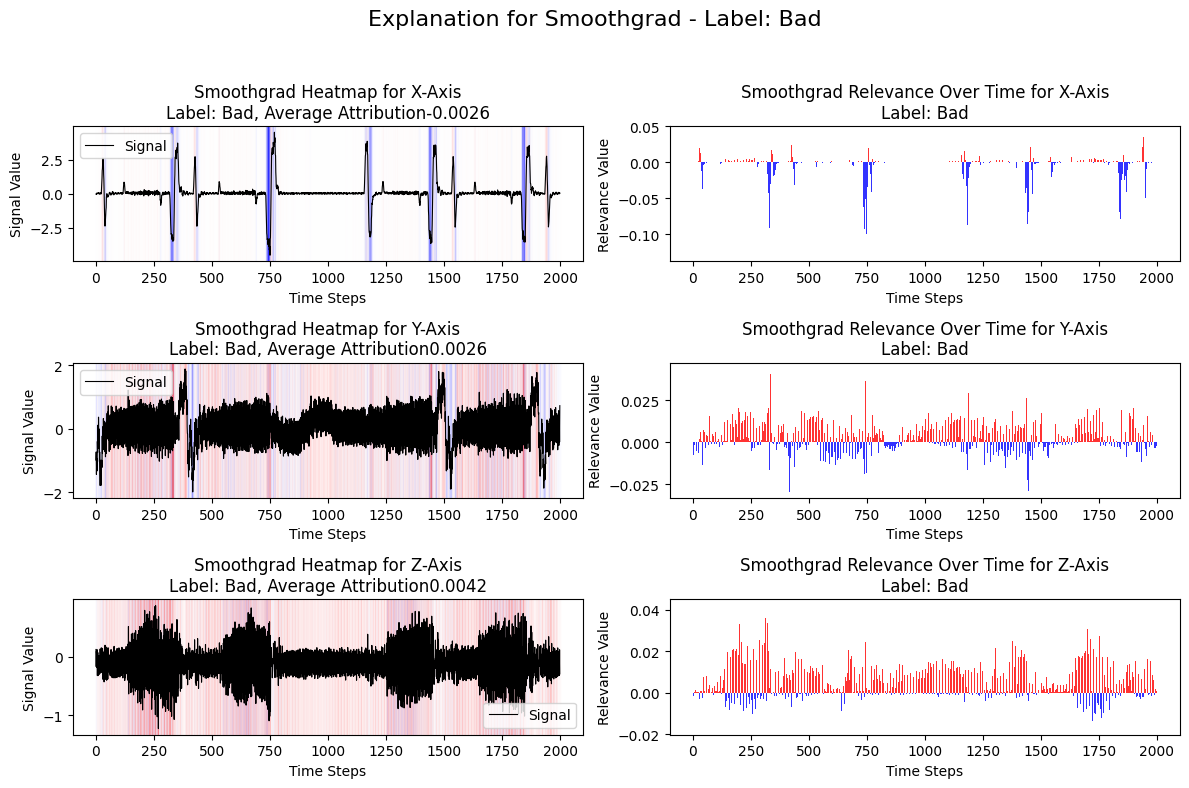

In [54]:
# SmoothGrad
smoothgrad_attr_b, _ = smoothgrad_relevance(freq_model, sample_b)
print(f"Min relevance: {np.min(smoothgrad_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, smoothgrad_attr_b, label_b, "Smoothgrad")


In [55]:
# Example usage
summary_b_sg = summarize_attributions(smoothgrad_attr_b.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_b_sg = []
for axis, values in summary_b_sg.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_sg.append(row)

# Create the DataFrame
df_summary_b_sg = pd.DataFrame(data_b_sg)

# Display the DataFrame as a table
print(df_summary_b_sg)# Flatten the summary dictionary and create a DataFrame


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1208                  1.905292   
1  Axis 1            1134                  8.555403   
2  Axis 2            1219                 10.232156   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.001577             792                 -7.087239   
1                    0.007544             866                 -3.384742   
2                    0.008394             781                 -1.863852   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.008949                    -5.181948   
1                   -0.003908                     5.170661   
2                   -0.002386                     8.368303   

   Average Relevance (Pos + Neg)  
0                      -0.002591  
1                       0.002585  
2                       0.004184  


Min relevance: -0.018729209899902344, Max relevance: 0.02170085906982422
 Maximum Absolute Attribution in Axis 0: 0.018729209899902344
 Maximum Absolute Attribution in Axis 1: 0.02170085906982422
 Maximum Absolute Attribution in Axis 2: 0.008160591125488281


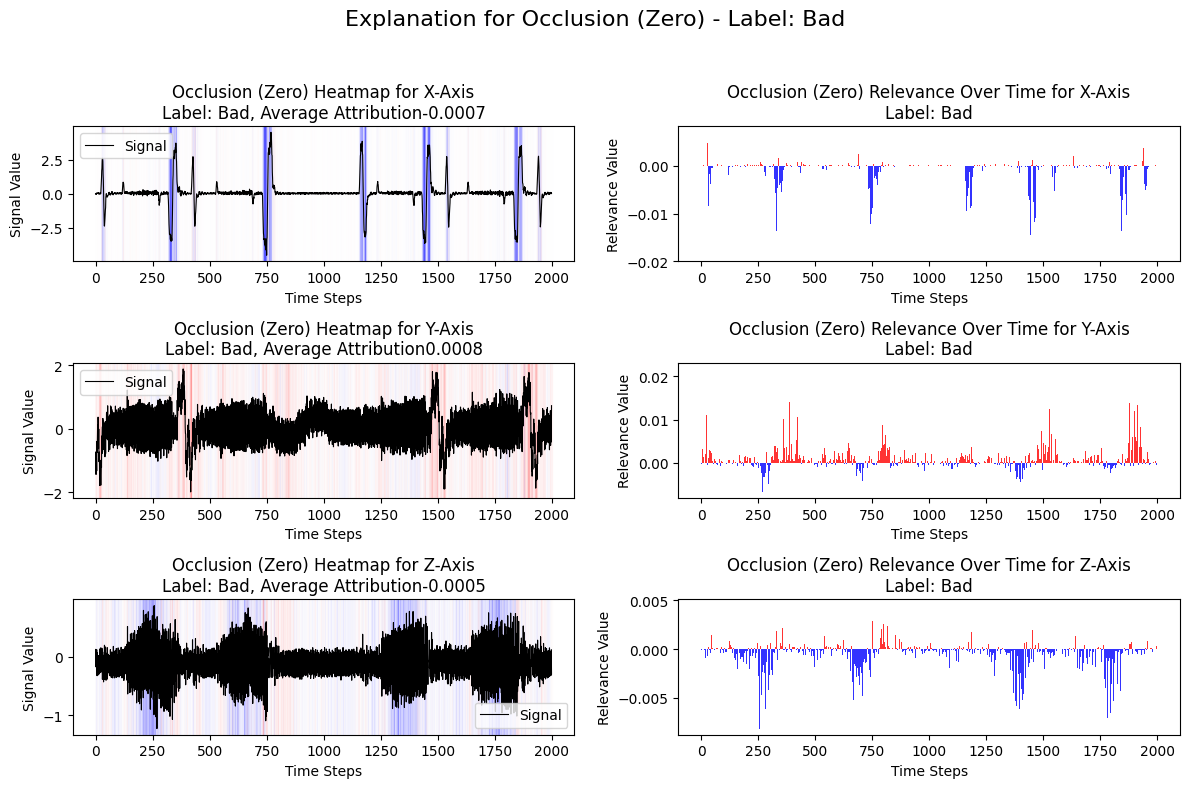

In [56]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_b, _ = occlusion_signal_relevance(freq_model, sample_b, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_zero_b, label_b, "Occlusion (Zero)")

Min relevance: -0.027444839477539062, Max relevance: 0.03622150421142578
 Maximum Absolute Attribution in Axis 0: 0.02451038360595703
 Maximum Absolute Attribution in Axis 1: 0.03622150421142578
 Maximum Absolute Attribution in Axis 2: 0.027444839477539062


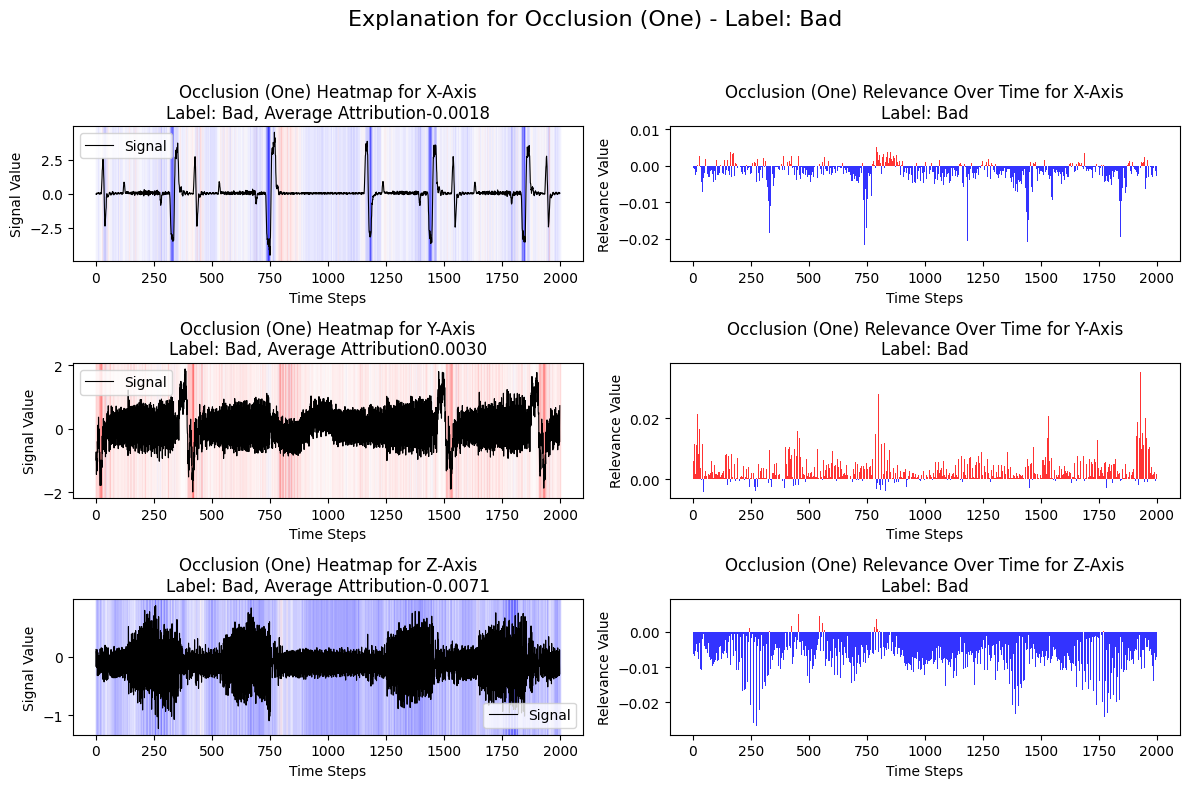

In [57]:
# Occlusion (one occlusion)
occlusion_attr_one_b, _ = occlusion_signal_relevance(freq_model, sample_b, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_one_b, label_b, "Occlusion (One)")

Min relevance: -0.022882461547851562, Max relevance: 0.027680397033691406
 Maximum Absolute Attribution in Axis 0: 0.017896175384521484
 Maximum Absolute Attribution in Axis 1: 0.027680397033691406
 Maximum Absolute Attribution in Axis 2: 0.022882461547851562


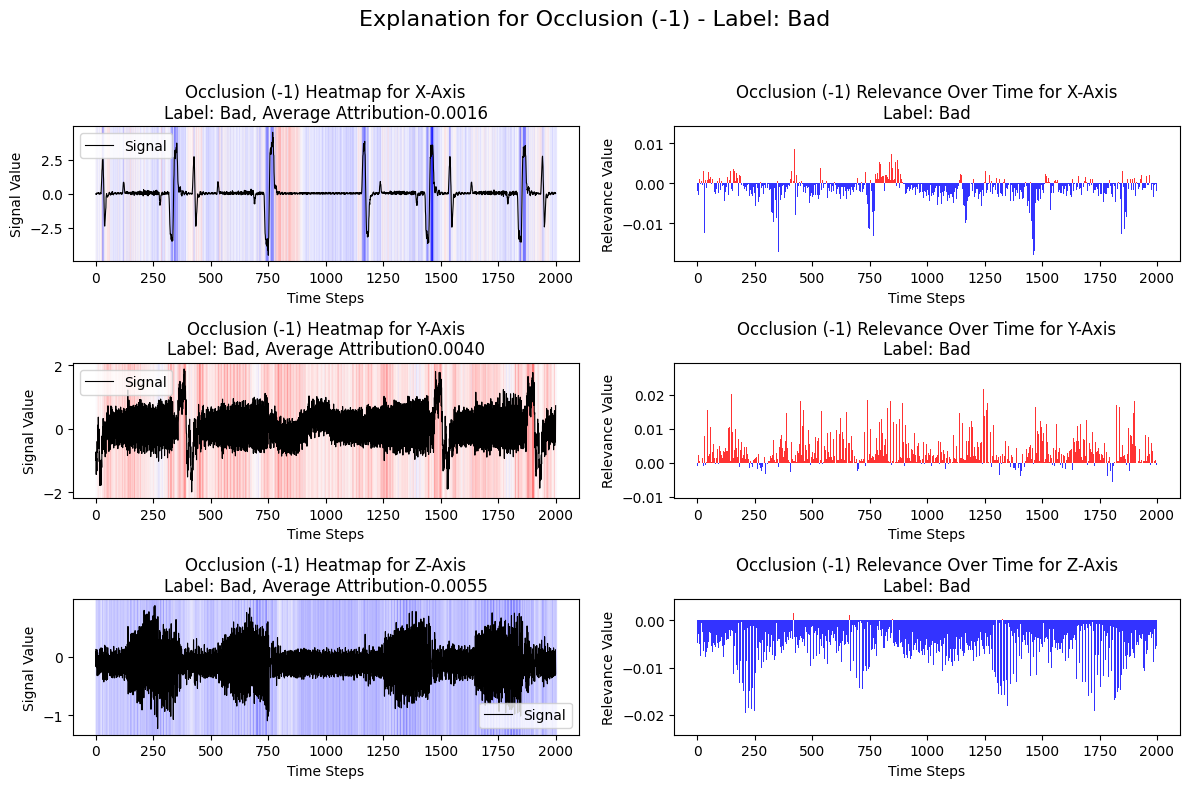

In [58]:
# Occlusion (-one occlusion)
occlusion_attr_mone_b, _ = occlusion_signal_relevance(freq_model, sample_b, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_mone_b, label_b, "Occlusion (-1)")

Min relevance: -0.038794517517089844, Max relevance: 0.05312299728393555
 Maximum Absolute Attribution in Axis 0: 0.038794517517089844
 Maximum Absolute Attribution in Axis 1: 0.05312299728393555
 Maximum Absolute Attribution in Axis 2: 0.025388240814208984


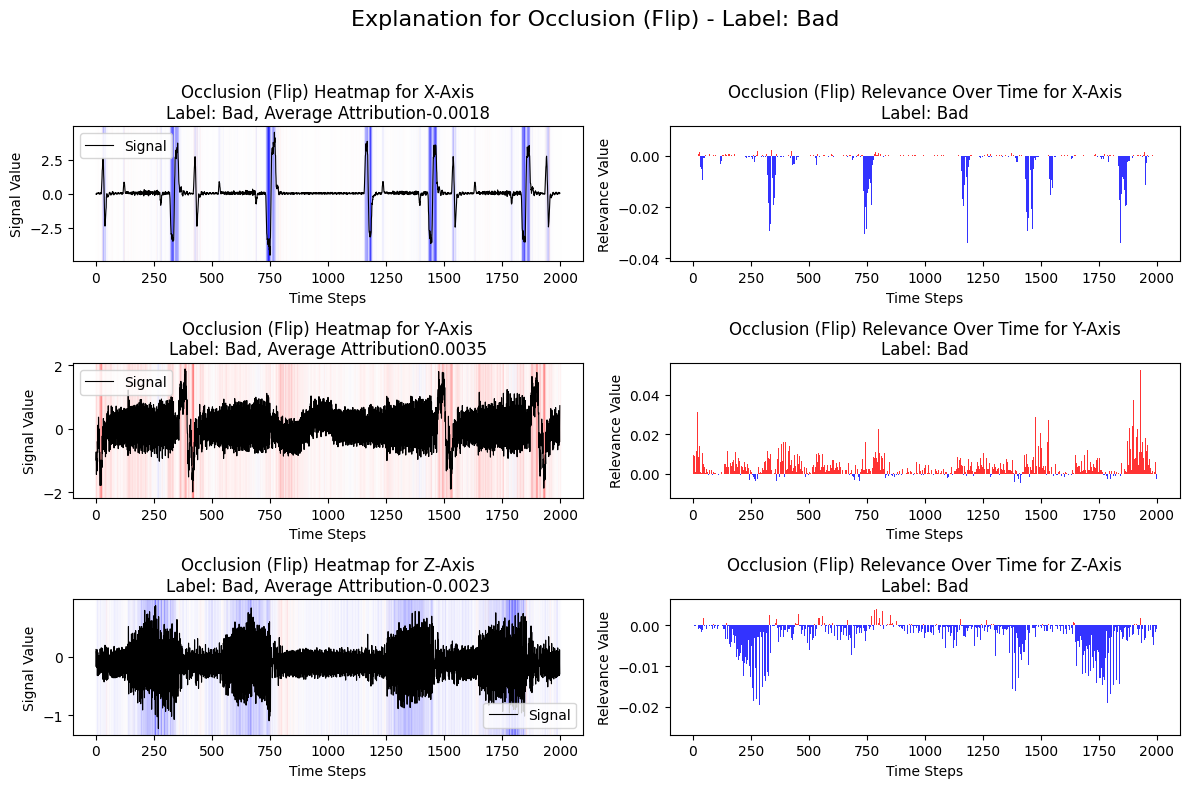

In [59]:

# Occlusion (e.g., zero-based occlusion)
occlusion_attr_flip_b, _ = occlusion_signal_relevance(freq_model, sample_b, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip_b.detach().cpu().numpy())}")

visualize_with_label_attribution(sample_b, occlusion_attr_flip_b, label_b, "Occlusion (Flip)")


Min relevance: -0.01645870879292488, Max relevance: 0.01659443788230419
 Maximum Absolute Attribution in Axis 0: 0.01645870879292488
 Maximum Absolute Attribution in Axis 1: 0.01659443788230419
 Maximum Absolute Attribution in Axis 2: 0.008298205211758614


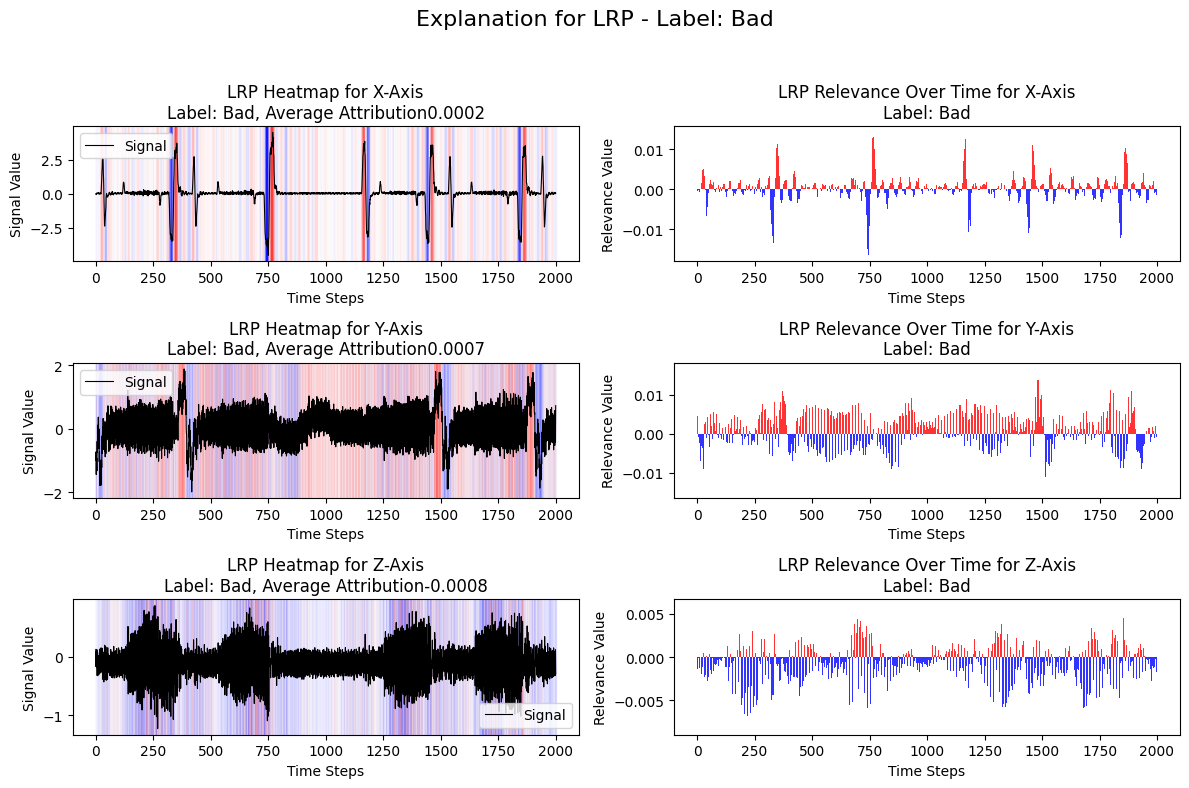

In [60]:

print(f"Min relevance: {np.min(relevance_b)}, Max relevance: {np.max(relevance_b)}")
visualize_with_label_attribution(sample_b, relevance_b, label_b, "LRP")


In [61]:
summary_b_of = summarize_attributions(occlusion_attr_flip_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data = []
for axis, values in summary_b_of.items():
    row = {"Axis": axis}
    row.update(values)
    data.append(row)

# Create the DataFrame
df_summary = pd.DataFrame(data)

# Display the DataFrame as a table
print(df_summary)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             802                  0.226437   
1  Axis 1            1597                  7.291996   
2  Axis 2             431                  0.224464   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.000282            1183                 -3.743249   
1                    0.004566             401                 -0.372177   
2                    0.000521            1560                 -4.822880   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.003164                    -3.516812   
1                   -0.000928                     6.919819   
2                   -0.003092                    -4.598416   

   Average Relevance (Pos + Neg)  
0                      -0.001772  
1                       0.003463  
2                      -0.002310  


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 104 Label: Bad


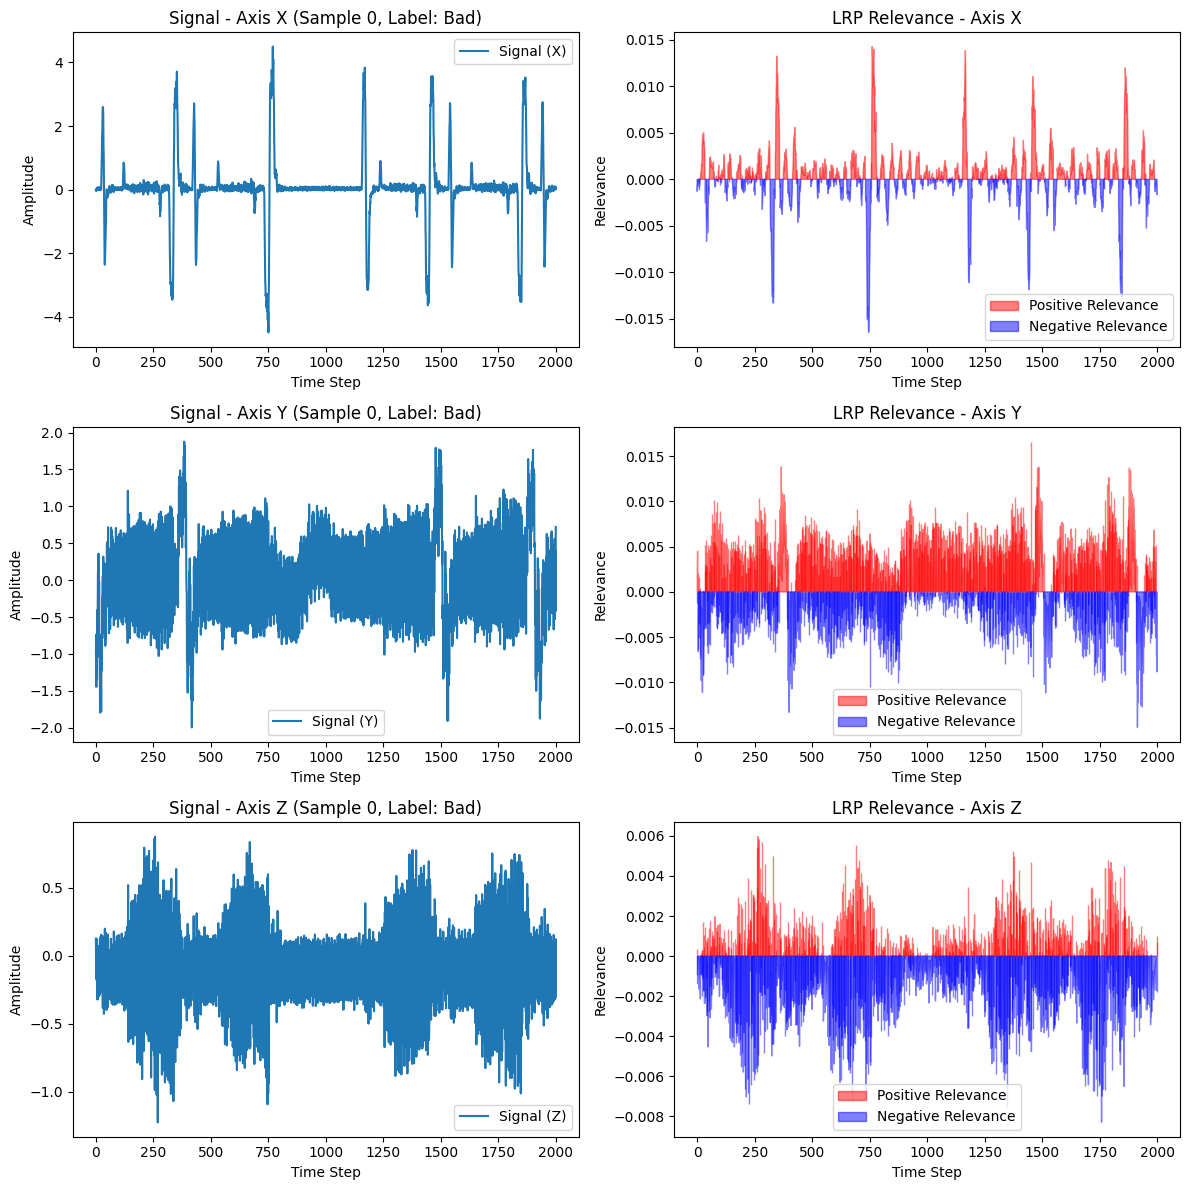

In [62]:
relevance_b, input_signal_b, final_label_b = compute_lrp_relevance(
    model=freq_model,
    sample=sample_b,  # Shape: (3, 10000) or torch tensor
    label=label_b,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index_b} Label: {'Good' if final_label_b == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal_b,
    relevance=relevance_b,
    label=final_label_b)

Min relevance: -0.01645870879292488, Max relevance: 0.01659443788230419
 Maximum Absolute Attribution in Axis 0: 0.01645870879292488
 Maximum Absolute Attribution in Axis 1: 0.01659443788230419
 Maximum Absolute Attribution in Axis 2: 0.008298205211758614


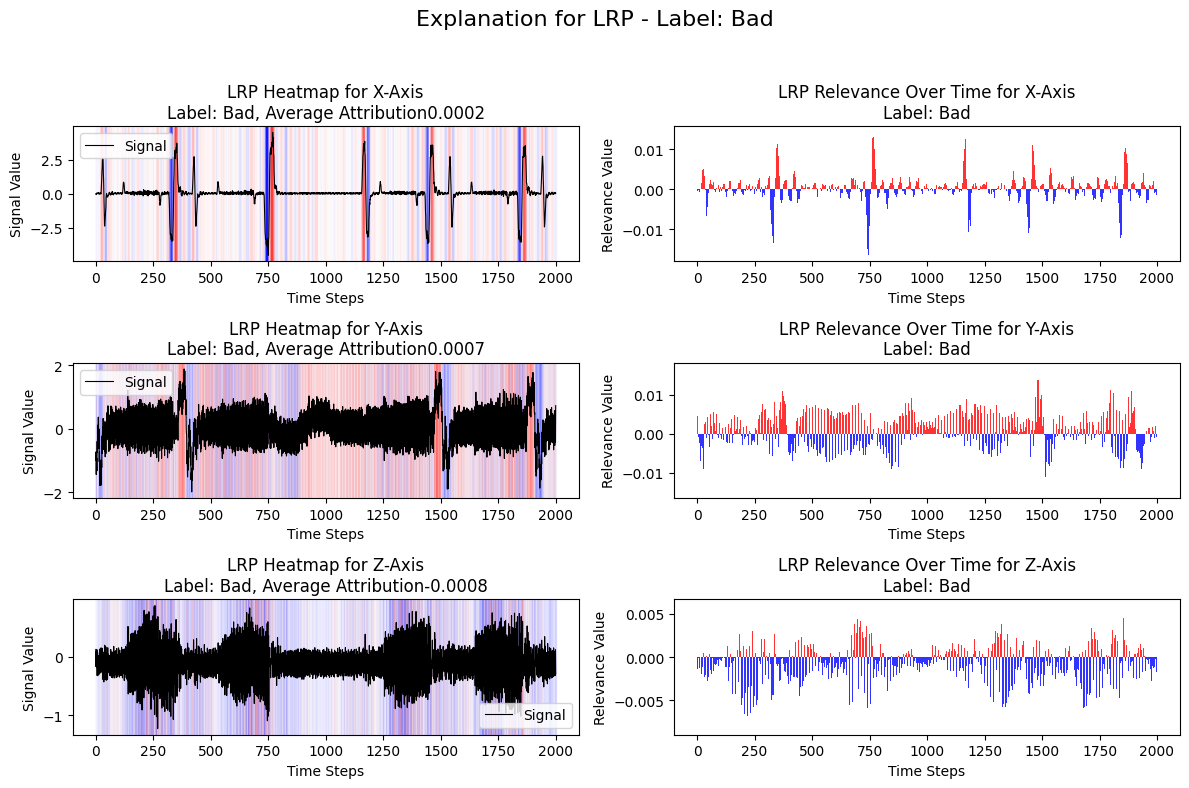

In [63]:

print(f"Min relevance: {np.min(relevance_b)}, Max relevance: {np.max(relevance_b)}")
visualize_with_label_attribution(sample_b, relevance_b, label_b, "LRP")


In [64]:
relevance_time_b, relevance_freq_b, signal_freq_b, input_signal_b, freqs_b, predicted_label_b = compute_dft_lrp_relevance(
        model=freq_model,
        sample=sample_b.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label_b.item(),
        device=device,
        signal_length=2000,
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Input sample shape: torch.Size([1, 3, 2000])
Relevance time shape: (3, 2000)
Input signal shape: (3, 2000)
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Number of axis is: 3
Frequency length is:1001
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relev

E:\Thesis\Datasets\CNC\utils\dft_lrp.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


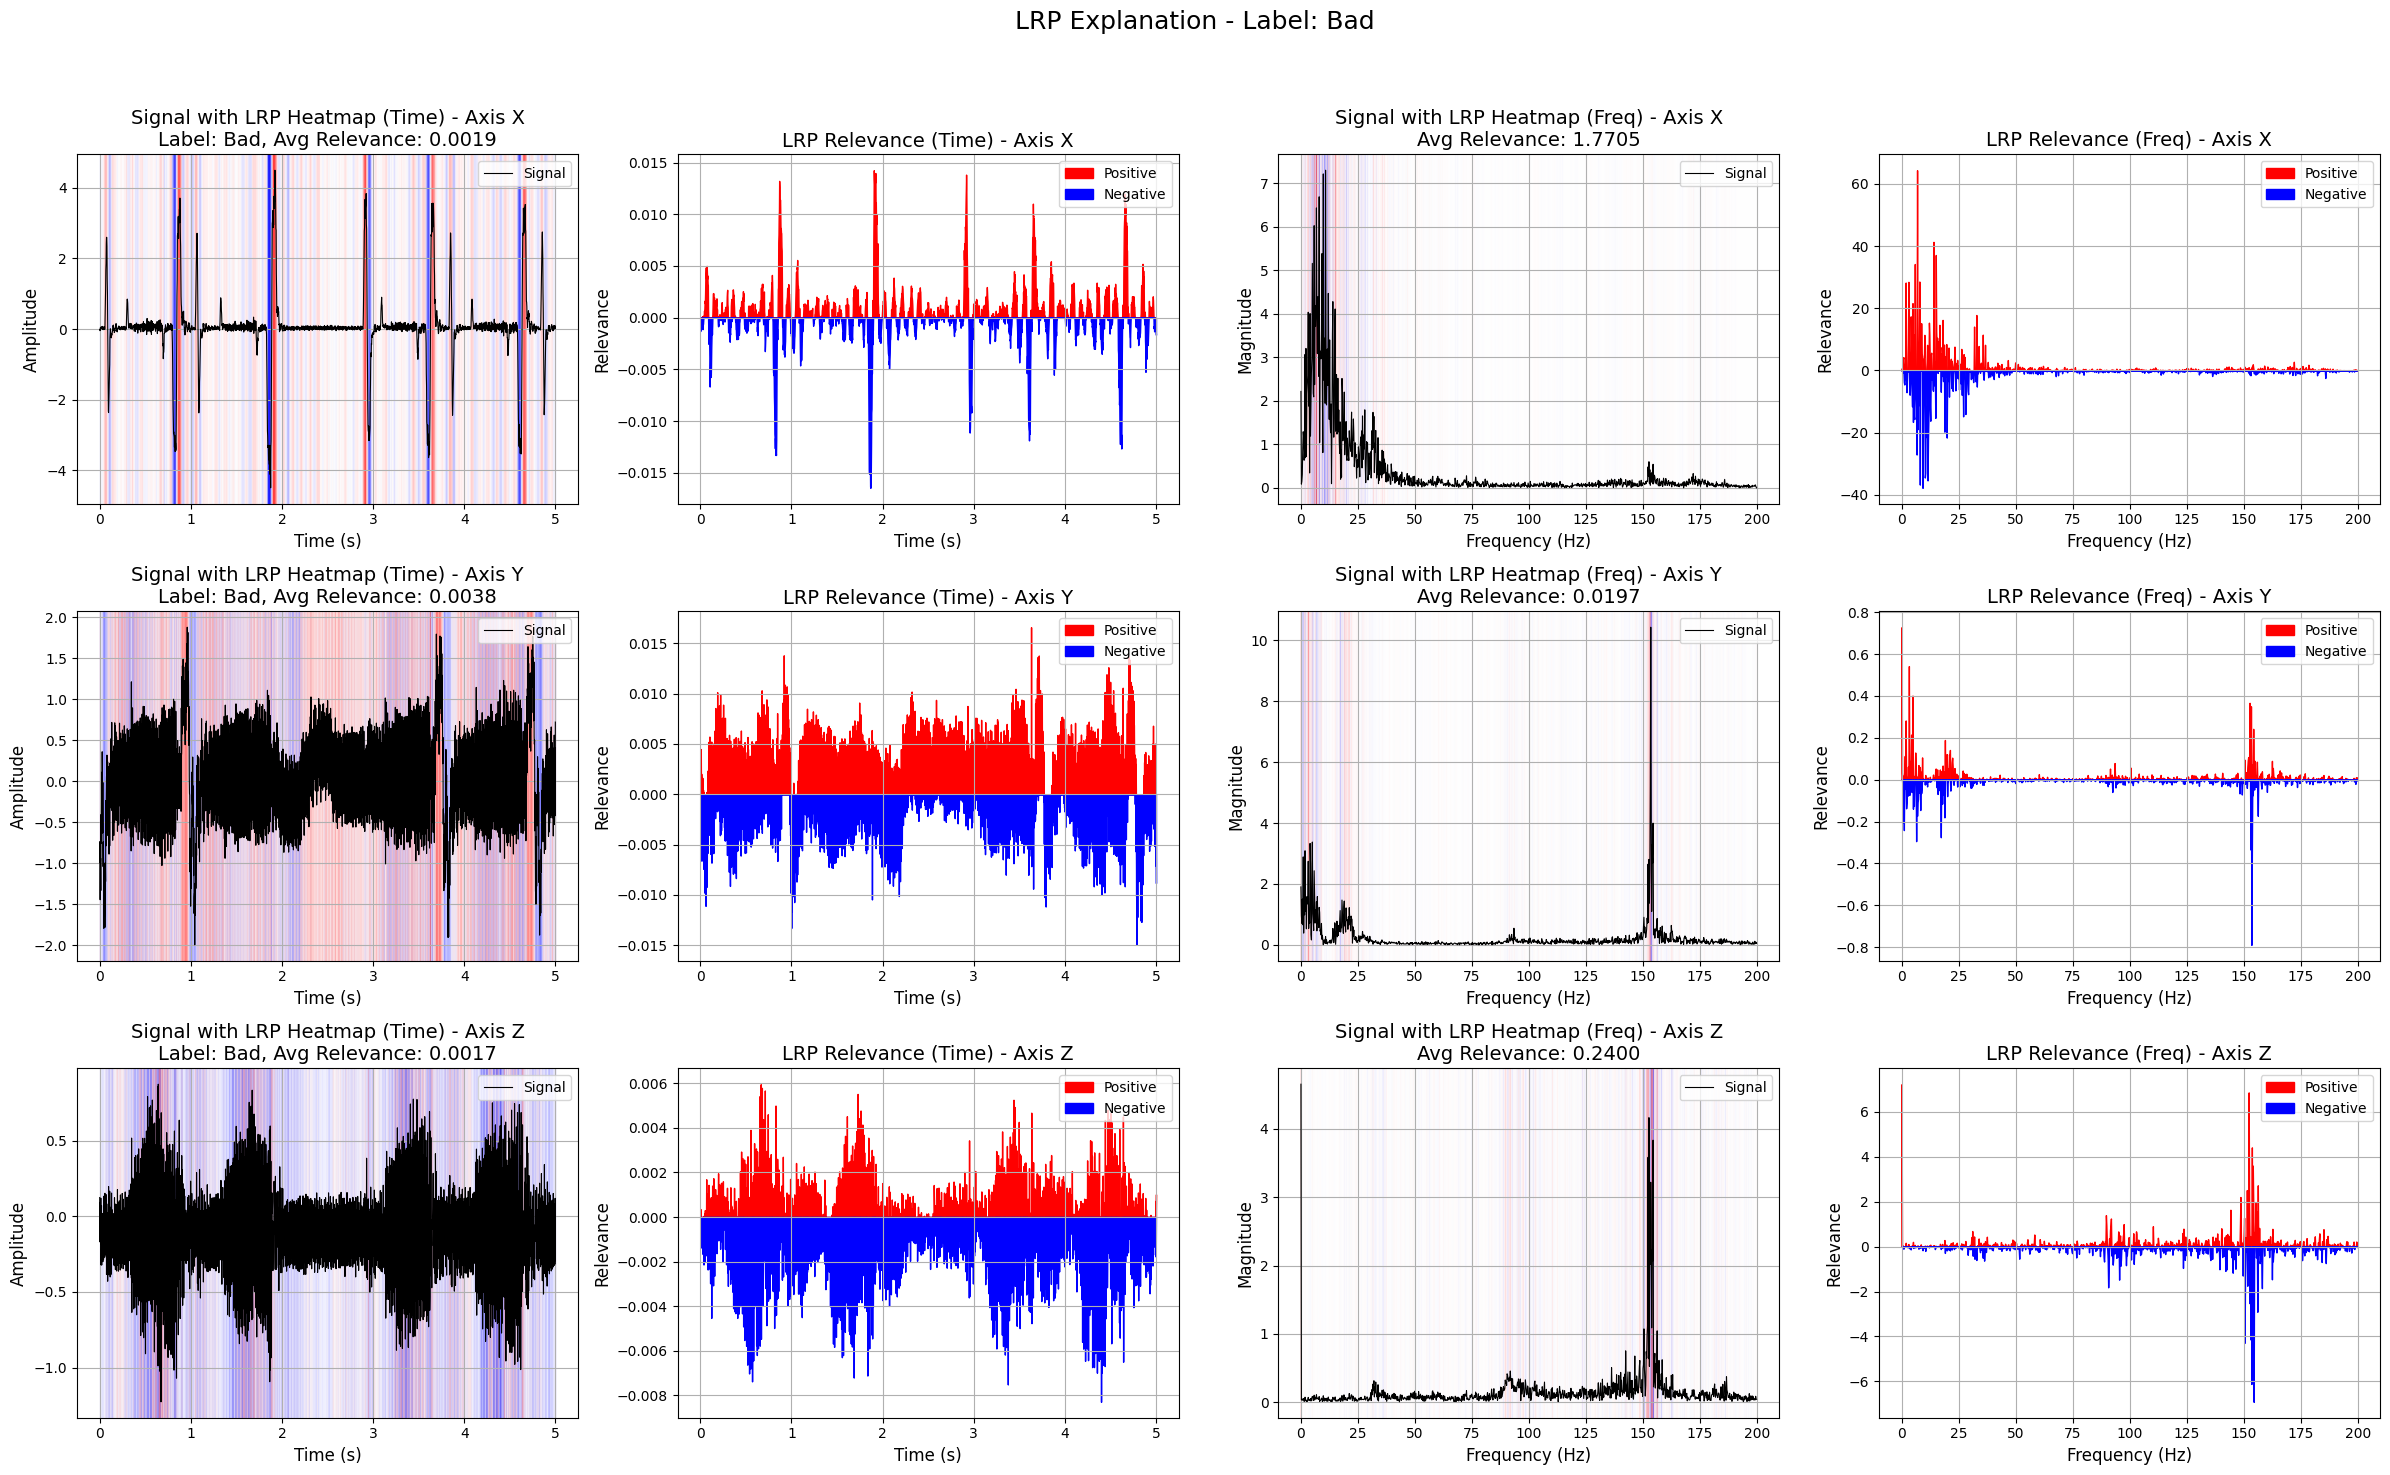

In [65]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time_b,
        relevance_freq=relevance_freq_b,
        signal_freq=signal_freq_b,
        input_signal=input_signal_b,
        freqs=freqs_b,
        predicted_label=predicted_label_b,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [66]:
summary_b_lrp = summarize_attributions( relevance_freq_b)  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_lrp = []
for axis, values in summary_b_lrp.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp.append(row)

# Create the DataFrame
df_summary_lrp = pd.DataFrame(data_lrp)

# Display the DataFrame as a table
print(df_summary_lrp)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             497                886.104409   
1  Axis 1             495                 10.589162   
2  Axis 2             492                119.347193   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    1.782906             504               -886.189268   
1                    0.021392             506                 -9.176877   
2                    0.242576             509               -120.893840   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -1.758312                    -0.084859   
1                   -0.018136                     1.412284   
2                   -0.237512                    -1.546647   

   Average Relevance (Pos + Neg)  
0                      -0.000085  
1                       0.001411  
2                      -0.001545  


In [67]:
""# Global Attribution over frequency with LRP
summary_lrp_t_b = summarize_attributions(relevance_time_b)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_t_b = []
for axis, values in summary_lrp_t_b.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_t_b.append(row)

# Create the DataFrame
df_summary_lrp_t_b = pd.DataFrame(data_lrp_t_b)

# Display the DataFrame as a table
print(df_summary_lrp_t_b)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1130                  2.119408   
1  Axis 1            1101                  4.451190   
2  Axis 2             683                  0.871640   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.001876             870                 -1.753231   
1                    0.004043             899                 -3.063274   
2                    0.001276            1317                 -2.459712   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.002015                     0.366176   
1                   -0.003407                     1.387917   
2                   -0.001868                    -1.588072   

   Average Relevance (Pos + Neg)  
0                       0.000183  
1                       0.000694  
2                      -0.000794  


In [68]:
relevance_time_fft_b, relevance_freq_fft_b, signal_freq_fft_b, relevance_timefreq_fft_b, signal_timefreq_fft_b, input_signal_fft_b, freqs_fft_b, predicted_label_fft_b = compute_fft_lrp_relevance(
        model=freq_model,
        sample=sample_b,
        label=None,
        signal_length=2000,
        sampling_rate=400,
        compute_timefreq=True,
        window_shift=50,  # Increased to reduce memory usage
        window_width=100,
        window_shape="rectangle"
    )

Input sample shape: torch.Size([1, 3, 2000])
Target label: 1
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
relevance_time_tensor shape before squeeze: (1, 3, 2000)
relevance_time shape after squeeze: (3, 2000)
input_signal shape: (3, 2000)
fft_lrp: Input relevance shape = (1, 2000), signal shape = (1, 2000)
fft_lrp: relevance_tensor shape = torch.Size([1, 2000]), signal_tensor shape = torch.Size([1, 2000])
fourier_transform: signal_tensor shape = torch.Size([1, 2000])
fourier_transform (FFT): signal_hat shape = torch.Size([1, 1001])
fft_lrp: signal_hat shape = torch.Size([1, 1001])
fft_lrp: relevance_normed shape = torch.Size([1, 2000])
fft_lrp: relevance_fft real part = tensor([[ 0.2714,  4.3615, -1.9358,  ...,  0.0801,  2.9327, -5.1185]],
       device='cuda:0')
fft_lrp: relevance_fft imag part = tensor([[ 0.0000, -1.3265, -3.1977,  ...,  2.1839, -1.0389,  0.0000]],
       device='cuda:0')
fft_lrp: relevance_hat real part before cpu = tensor([[

In [69]:

# Global Attribution for FFT_LRP over frequency
summary_fft_freq_b = summarize_attributions(relevance_freq_fft_b)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_freq_b = []
for axis, values in summary_fft_freq_b.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_freq_b.append(row)

# Create the DataFrame
df_summary_fft_freq_b = pd.DataFrame(data_fft_freq_b)

# Display the DataFrame as a table
print(df_summary_fft_freq_b)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             498  1171.861145+   0.000000j   
1  Axis 1             494    21.099051+   0.000000j   
2  Axis 2             491   372.623138+   0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          2.353135+0.000000j             503 -1160.694611+   0.000000j   
1          0.042711+0.000000j             507   -21.989407+   0.000000j   
2          0.758907+0.000000j             510  -365.223762+   0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -2.307544+0.000000j         11.166533+ 0.000000j   
1         -0.043372+0.000000j         -0.890356+ 0.000000j   
2         -0.716125+0.000000j          7.399375+ 0.000000j   

   Average Relevance (Pos + Neg)  
0             0.011155+0.000000j  
1            -0.000889+0.000000j  
2             0.007392+0.000000j  


In [70]:
# Global Attribution for FFT_LRP over time frequency
summary_fft_timefreq_b = summarize_attributions(relevance_timefreq_fft_b)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_timefreq_b = []
for axis, values in summary_fft_timefreq_b.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_timefreq_b.append(row)

# Create the DataFrame
df_summary_fft_timefreq_b = pd.DataFrame(data_fft_timefreq_b)

# Display the DataFrame as a table
print(df_summary_fft_timefreq_b)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0           10132  4190.404640+   0.000000j   
1  Axis 1            9923    57.541811+   0.000000j   
2  Axis 2            9619  1562.063415+   0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          0.413581+0.000000j            9887 -4109.117949+   0.000000j   
1          0.005799+0.000000j           10097   -52.709239+   0.000000j   
2          0.162394+0.000000j           10401 -1660.698019+   0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -0.415608+0.000000j         81.286691+ 0.000000j   
1         -0.005220+0.000000j          4.832572+ 0.000000j   
2         -0.159667+0.000000j        -98.634604+ 0.000000j   

   Average Relevance (Pos + Neg)  
0             0.004060+0.000000j  
1             0.000241+0.000000j  
2            -0.004927+0.000000j  


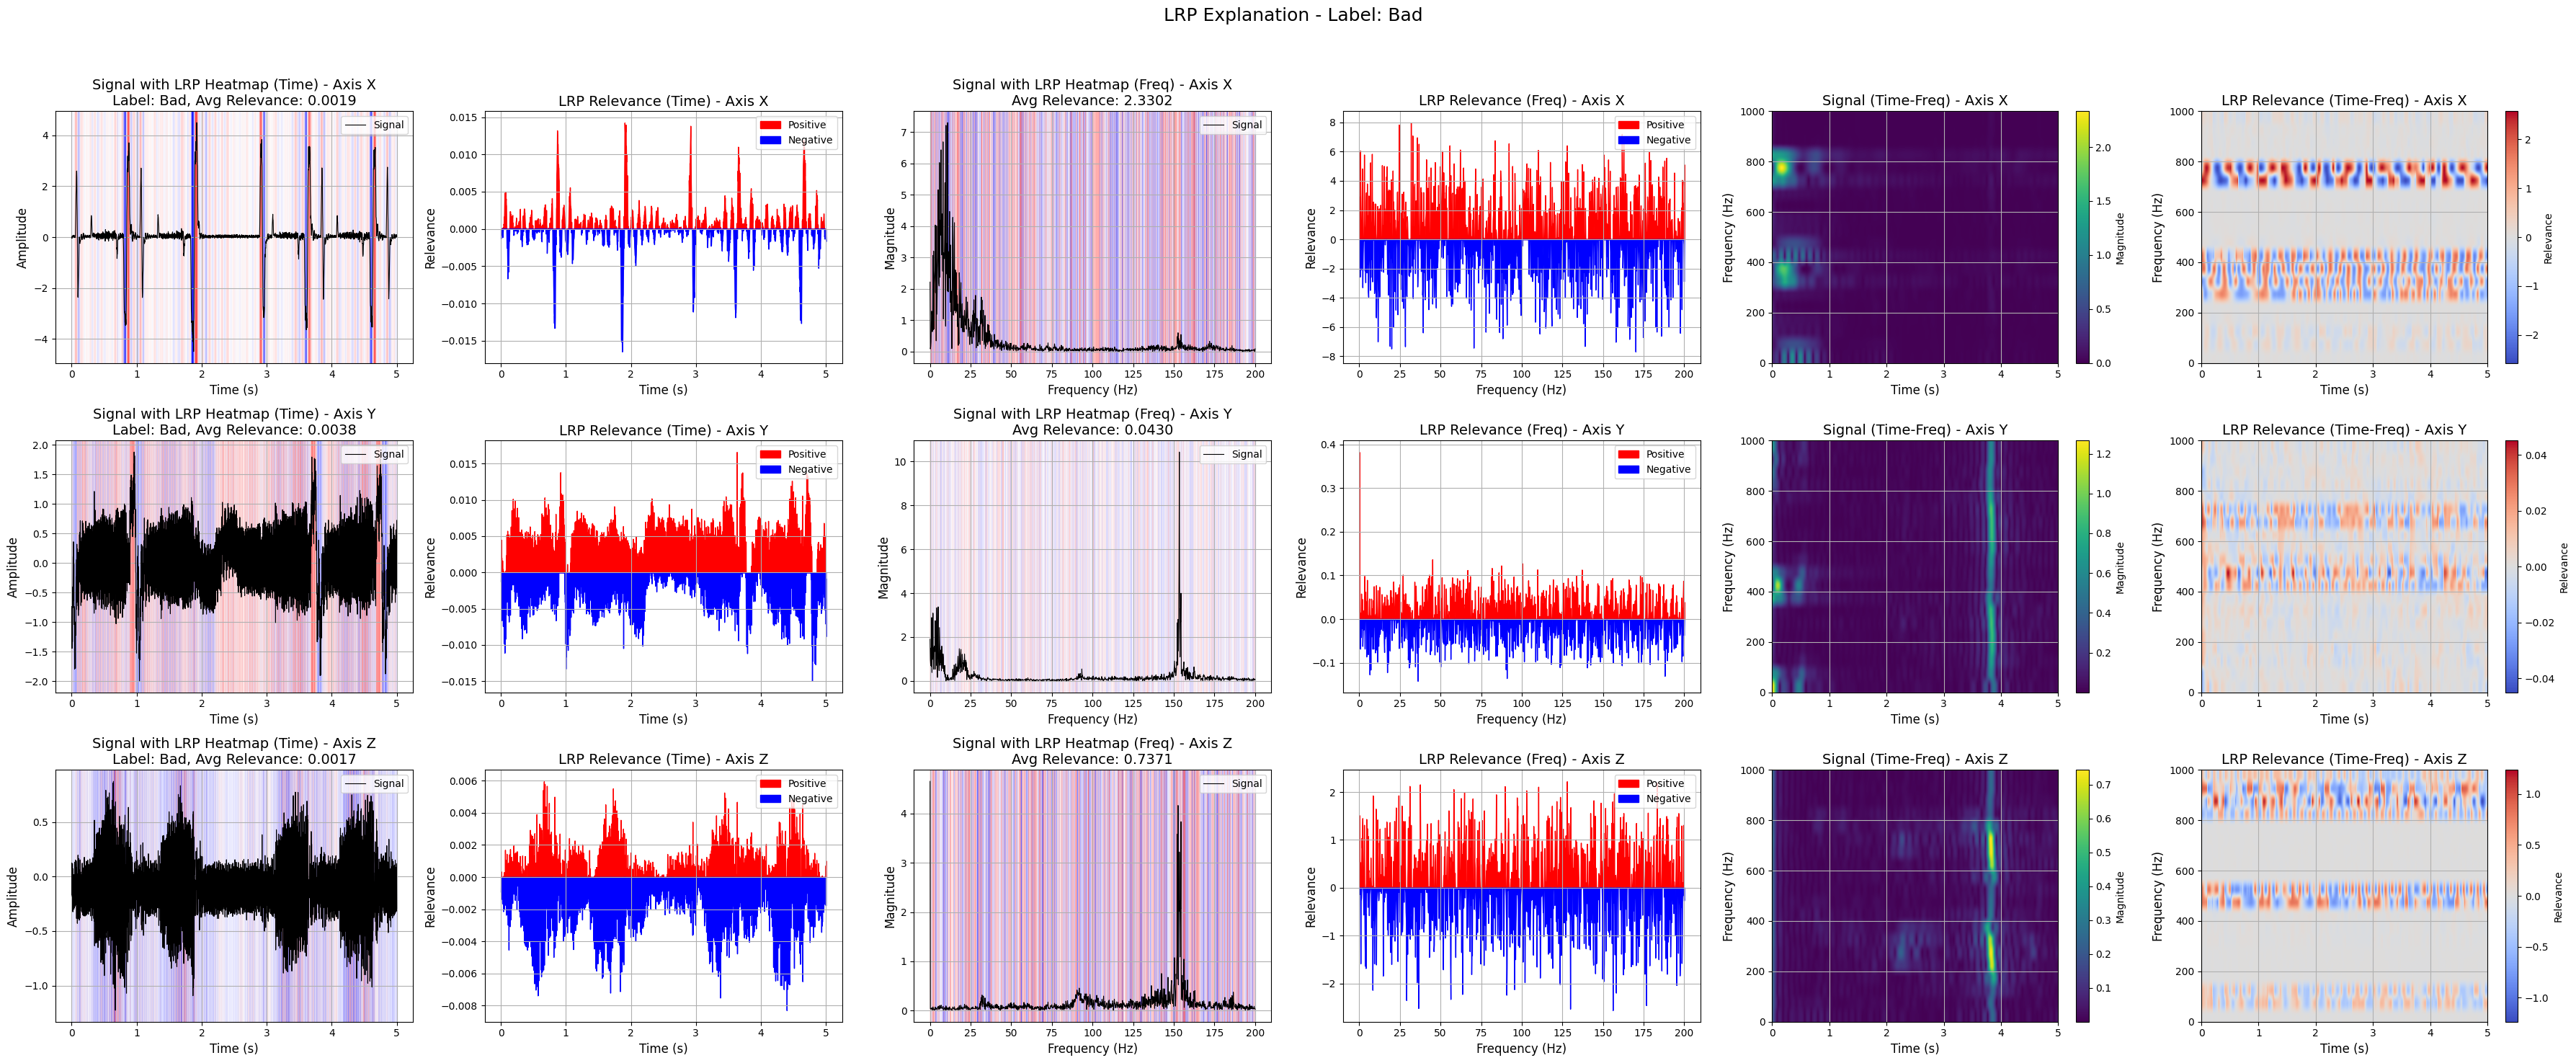

In [71]:
# Visualize
visualize_lrp_fft(
    relevance_time=relevance_time_fft_b,
    relevance_freq=relevance_freq_fft_b,
    signal_freq=signal_freq_fft_b,
    relevance_timefreq=relevance_timefreq_fft_b,
    signal_timefreq=signal_timefreq_fft_b,
    input_signal=input_signal_fft_b,
    freqs=freqs_fft_b,
    predicted_label=predicted_label_fft_b,
    signal_length=2000,
    sampling_rate=400,
    k_max=1000
)